FOM_DATA_QWI_x = []
FOM_DATA_QWI_y = []
FOM_DATA_QWI_y_all = []
max_shift = 50
num_runs = 20
num_electric_fields = 1 # simulation cxx - not python
max_electric_field = 20
num_fields = 5

for k in range(num_fields):
    FOM_DATA_QWI_y = []
    for j in range(num_runs):
        wavelength_shift = max_shift/num_runs + j*max_shift/num_runs
        QWI_params = ["True", wavelength_shift]
        FOM_DATA_QWI_x.append(wavelength_shift)
        write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field/num_fields+k*max_electric_field/num_fields)

        # Run the C++ executable with material and layer files
        subprocess.run(['simulation.exe'])
        WL_range=[1200,1700]
        WL_of_interest=[1450,1700]
        FOM_DATA_QWI_y.append(show_results(num_electric_fields+1, WL_of_interest, WL_range))
    FOM_DATA_QWI_y_all.append(FOM_DATA_QWI_y)

In [229]:
import numpy as np
import scipy
import matplotlib.pyplot as plt 
from numpy.linalg import eig
import matplotlib.animation as animation
from IPython.display import clear_output
import subprocess
import random
from datetime import datetime

In [230]:
import numpy as np
import scipy
import matplotlib.pyplot as plt 
from numpy.linalg import eig
import matplotlib.animation as animation
from IPython.display import clear_output
import subprocess
import random
from datetime import datetime

def getXY(BG_in):
    # Define the command to run the compiled C++ executable
    executable_path = r'C:\Users\jmcc0\Desktop\FYP\Frank code\getXY.exe'
    run_command = [executable_path]

    # Run the compiled C++ code
    process = subprocess.Popen(run_command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, cwd=r'C:\Users\jmcc0\Desktop\FYP\Frank code')

    # Provide input to the C++ program
    BG = BG_in
    process.stdin.write(str(BG).encode())
    process.stdin.close()

    # Read the output from the C++ program
    output = process.stdout.read().decode().strip()
    x_str, y_str = output.split('\t')
    x = float(x_str.split('=')[1])
    y = float(y_str.split('=')[1])
    # Now you have the x and y values from the C++ code
    print("x =", x)
    print("y =", y)
    
    return x, y

def getGap(layers):
    with open('input.txt', 'w') as f:
        f.write(str(int(len(layers))) + "\n")
        for layer in layers:
            f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")
    with open('materials.txt', 'w') as f:
        for material in materials:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        for material in alloys:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    
    executable_path = r'C:\Users\jmcc0\Desktop\FYP\QWI\getGap.exe'
    run_command = [executable_path]
    process = subprocess.Popen(run_command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, cwd=r'C:\Users\jmcc0\Desktop\FYP\QWI')
    
    output = process.stdout.read().decode().strip()
    lines = output.split('\n')

    # Initialize variables to store the values
    energy_e = None
    energy_lh = None
    energy_hh = None

    # Process each line
    for line in lines:
        parts = line.split(':')
        if len(parts) == 2:  # Ensure the line has a label and a value
            label = int(parts[0])
            value = float(parts[1])
            if label == 0:
                energy_e = value
            elif label == 1:
                energy_lh = value
            elif label == 2:
                energy_hh = value
    
    return max(1240/abs(energy_e-energy_lh), 1240/abs(energy_e-energy_hh))

# voigt function details
num_discrete = 2048
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = num_discrete/2
gamma = 50
sigma = gamma
PLOT_LIMIT=[]

def pad_func_zeros(func):
    func_new = np.zeros(2*len(func))
    j = 0
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    return func_new # twice in length

def pad_func_linear(func):
    func_new = np.zeros(2*len(func))
    j = 0
    del_f = np.abs(func[1]-func[2])
    for i in range(0, int(0.25*len(func_new))):
        func_new[i] = func[0]-0.5*(func[len(func)-1]-func[0]) + i*del_f
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    w=j-1
    j=1
    for i in range(int(0.75*len(func_new)), len(func_new)):
        func_new[i] = func[w] + j*del_f
        j+=1
    return func_new # twice in length

def pad_E(f):
    del_f = np.max(f)/(num_discrete-1)
    func_new = np.zeros(2*len(f))
    j = 0
    for i in range(len(func_new)):
        func_new[i] = del_f*i
    return func_new # twice in length

def convolve(f, g): # PAD ARRAYS BEFORE USE FRO ABSORPTION
    FFT_f = np.fft.fft(f)
    FFT_g = np.fft.fft(g)
    FG = FFT_f * FFT_g
    result = np.fft.ifft(FG)
    return np.real(result)

# plotting
PLOT_LIMIT = []#400,800]
Y_LIMIT = [] # leave blank for auto
ERROR_BARS = False
PLOT_FITTED = False
split_ = ","
LABEL_FONT_SIZE = 13
TICK_FONT_SIZE = 11
LINE_WIDTH = 0.5
MARKER_SIZE = 1
LEGEND = True
label_x = ""
label_y = ""
plot_title = ""
aspect_ratio = [9,9]

colours = [ 'black', 'dimgrey', 'lightslategrey', 'lightsteelblue', 'silver', 'cadetblue', 'darkcyan', 'darkslategray', 'seagreen', 'mediumseagreen', 'darkolivegreen', 'olivedrab', 'olive', 'yellowgreen', 'green', 'springgreen', 'mediumspringgreen', 'turquoise', 'lightseagreen']

def plot_graph(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (aspect_ratio[0],aspect_ratio[1])
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize = TICK_FONT_SIZE)
    plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    plt.plot(x, y, linewidth = LINE_WIDTH, color = 'dimgrey', marker = 's', markersize = MARKER_SIZE, markerfacecolor='dimgrey')
    plt.grid(True, alpha=0.2)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def plot_graphs(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #plt.xticks(fontsize = TICK_FONT_SIZE)
    #plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    i=0
    for ys in y:
        if i < len(colours):
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE, color = colours[i])
        else:
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE)
        i+=1
    plt.grid(True, alpha=0.2)
    if(LEGEND==True):
        plt.legend(legend)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()
    
def plot_graphs_distinct(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #plt.xticks(fontsize = TICK_FONT_SIZE)
    #plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    i=0
    for ys in y:
        if i < len(colours):
            plt.plot(x[i], ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE, color = colours[i])
        else:
            plt.plot(x[i], ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE)
        i+=1
    plt.grid(True, alpha=0.2)
    if(LEGEND==True):
        plt.legend(legend)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def make_array(y, number_steps):
    p = np.zeros(number_steps)
    for nr in range(0, number_steps):
        p[nr] = y
    return p

def read_in(file_path):
    x_data_ = []
    y_data_ = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split the line into x and y values
                x_val, y_val = map(float, line.strip().split())
                x_data_.append(x_val)
                y_data_.append(y_val)
    except FileNotFoundError:
        print("File not found:", file_path)

    # Convert lists to numpy arrays
    x_array_ = np.array(x_data_)
    y_array_ = np.array(y_data_)
    
    #plot_graph(x_array_, y_array_)
    
    return x_array_, y_array_

In [231]:
def parse_input_file(input_file):
    layers = []
    with open(input_file, 'r') as f:
        num_layers = int(f.readline().strip())
        for _ in range(num_layers):
            layer_info = f.readline().strip().split()
            material = layer_info[0]
            thickness = float(layer_info[1])
            layers.append((material, thickness))
    return layers

def parse_materials_file(materials_file):
    materials = {}
    with open(materials_file, 'r') as f:
        for line in f:
            material_info = line.strip().split()
            material = material_info[0]
            properties = [float(prop) for prop in material_info[1:]]
            materials[material] = properties
    return materials

def parse_simulation_parameters_file(simulation_params_file):
    with open(simulation_params_file, 'r') as f:
        qwi_target_shift = float(f.readline().split(" ")[1])
        num_electric_fields = int(f.readline().strip())
        max_applied_efield = float(f.readline().strip())
    return qwi_target_shift, num_electric_fields, max_applied_efield

In [232]:
def write_simulation_parameters(inter_mixing_params, num_electric_fields, max_electric_field):
    with open('simulation_parameters.txt', 'w') as f:
        f.write(f"{inter_mixing_params[0]} {inter_mixing_params[1]}\n")
        f.write(f"{num_electric_fields}\n")
        f.write(f"{max_electric_field}\n")

class Layer:
    def __init__(self, material, thickness): # thickness in [A]
        self.material = material
        self.thickness = thickness

class Material:
    def __init__(self, name, affinity, band_gap, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive):
        self.affinity = affinity
        self.band_gap = band_gap
        self.e_eff_mass = e_eff_mass
        self.lh_eff_mass = lh_eff_mass
        self.hh_eff_mass = hh_eff_mass
        self.name = name
        self.refractive = refractive
        
    def getEffectiveMass(self, p):
        if p == 0:
            return self.e_eff_mass
        if p == 1:
            return self.lh_eff_mass
        if p == 2:
            return self.hh_eff_mass
        
    def getBandgap(self):
        return self.band_gap
    
    def getRefractive(self):
        return self.refractive
    
# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.063, 0.082, 0.51, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.14, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.026, 0.41, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []
def BG_InGaAlAs(x, y):
    return 0.36 + 2.093*y + 0.629*x + 0.577*y*y + 0.436*x*x + 1.013*x*y - 2.0*x*y*(1-x-y); # [eV]
def EF_InGaAlAs(x, y): # Effective electron finity for placing conduction bands InGaAlAs
    return 0.5766 - 0.3439*BG_InGaAlAs(x, y) # [eV] 
def effMass_InGaAlAs(x, y, particle):
    return InAs.getEffectiveMass(particle)*(1-x-y) + GaAs.getEffectiveMass(particle)*(x) + AlAs.getEffectiveMass(particle)*(y);
def refractive_InGaAlAs(x, y):
    E_g = BG_InGaAlAs(x,y);
    x=(E_g-0.75)/0.72;
    w = 1240/E_g
    if (x>1.0): x = 1
    A = 9.689 - 1.012*x;
    B = 1.590 - 0.376*x;
    C = 1102.4 - 702.0*x + 330.4*x*x;
    if (C+100 < w):
        X = w*w-C*C
    else: 
        X = (200*w+10000)
    return np.sqrt(A + B*w*w/X);
def InGaAlAs_material(bandgap): # in nm
    bandgap = 1240/bandgap
    x, y = getXY(bandgap)
    print("x="+str(x)+" y="+str(y))
    temp = Material("In{}Ga{}Al{}As".format(1-x-y,x,y), EF_InGaAlAs(x, y), BG_InGaAlAs(x, y), effMass_InGaAlAs(x, y, 0), effMass_InGaAlAs(x, y, 1), effMass_InGaAlAs(x, y, 2), refractive_InGaAlAs(x,y))
    print("BG:" + str(BG_InGaAlAs(x, y)))
    alloys.append(temp)
    return temp

def findAlloys(layers, target):
    sigma = 2500
    sigma0 = 500
    sigma_prev = sigma0
    i = 0
    while i < 20:
        for layer in layers:
            if layer.material.name != 'InP':  # Exclude InP layers from modification
                old_bandgap = 1240/layer.material.band_gap
                new_bandgap = old_bandgap + (target - getGap(layers))  # Adjust each layer's bandgap individually
                layer.material = InGaAlAs_material(new_bandgap)
        with open('input.txt', 'w') as f:
            f.write(str(int(len(layers))) + "\n")
            for layer in layers:
                f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

        with open('materials.txt', 'w') as f:
            for material in materials:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
            for material in alloys:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

        testGap = getGap(layers)
        temp = sigma
        print(testGap)
        if testGap > target + 1:
            sigma = (sigma0 + sigma) / 2.0
            sigma_prev = temp
        elif testGap < target - 1:
            sigma0 = sigma
            sigma = (sigma_prev + sigma) / 2.0
        else:
            break
        i += 1
    if(i>=20): success = False
    else: success = True
    print("out: " + str(testGap))
    return layers, success

In [238]:
layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer6 = Layer(GaP, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1610), 150)
layer2 = Layer(InGaAlAs_material(1700), 150)
layer3 = Layer(InGaAlAs_material(1550), 180)
layer7 = Layer(InGaAlAs_material(1200), 30)

layer3 = Layer(InGaAlAs_material(2000.81), 100)
InP_layer = Layer(InGaAlAs_material(1300.85), 100)
layers = [InP_layer, layer3, InP_layer]

print("Initial Bandgap: " + str(getGap(layers)))

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

num_electric_fields = 10 # simulation cxx - not python
max_electric_field = 10
wavelength_shift = 50 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
#subprocess.run(['simulation_multithread.exe'])

x = 0.449376
y = 0.0189702
x=0.449376 y=0.0189702
BG:0.7701862290418768
x = 0.468033
y = -1.11468e-15
x=0.468033 y=-1.11468e-15
BG:0.7499006886428017
x = 0.423147
y = 0.0456408
x=0.423147 y=0.0456408
BG:0.8000003493770904
x = 0.250731
y = 0.220956
x=0.250731 y=0.220956
BG:1.0333334315677287
x = 0.468033
y = -1.11468e-15
x=0.468033 y=-1.11468e-15
BG:0.7499006886428017
x = 0.304793
y = 0.165985
x=0.304793 y=0.165985
BG:0.9532231452239134
Initial Bandgap: 1569.3957699721434


In [242]:
# UPDATED

GaAs = Material("GaAs", 0.111,  1.42, 0.063, 0.082, 0.51, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.14, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.026, 0.41, 3.714)
AlAs = Material("AlAs", -0.4245, 2.5255, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]

layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer6 = Layer(GaP, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1610), 150)
layer3 = Layer(InGaAlAs_material(1550), 180)
layer7 = Layer(InGaAlAs_material(1200), 30)

layer3 = Layer(InGaAlAs_material(1649.81), 100)
InP_layer = Layer(InGaAlAs_material(1300), 100)
layers = [InP_layer, layer3, InP_layer]

print("Initial Bandgap: " + str(getGap(layers)))

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

num_electric_fields = 10 # simulation cxx - not python
max_electric_field = 10
wavelength_shift = 0 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
# subprocess.run(['simulation_multithread.exe'])

x = 0.449376
y = 0.0189702
x=0.449376 y=0.0189702
BG:0.7701862290418768
x = 0.423147
y = 0.0456408
x=0.423147 y=0.0456408
BG:0.8000003493770904
x = 0.250731
y = 0.220956
x=0.250731 y=0.220956
BG:1.0333334315677287
x = 0.46644
y = 0.00161901
x=0.46644 y=0.00161901
BG:0.7516013310512202
x = 0.304355
y = 0.16643
x=0.304355 y=0.16643
BG:0.9538459111398105
Initial Bandgap: 1566.2755609224355


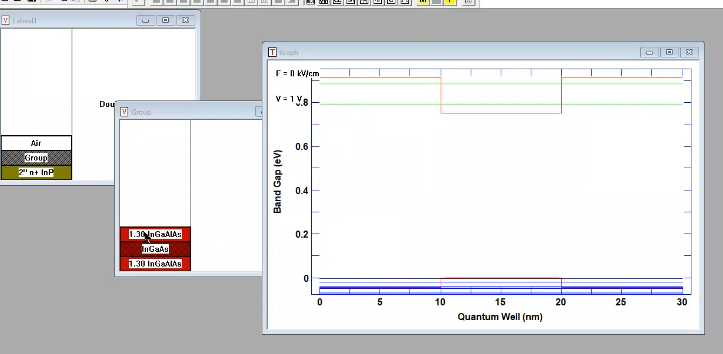

In [211]:
layers, check = findAlloys(layers, 1550)

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")
        
num_electric_fields = 10 # simulation cxx - not python
max_electric_field = 10
wavelength_shift = 0 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
# FOM_DATA_QWI_x.append(wavelength_shift)
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
# subprocess.run(['simulation_multithread.exe'])

x = 0.358825
y = 0.111044
0.8794850456452873
x = 0.445762
y = 0.0226451
0.7742046260815404
x = 0.363948
y = 0.105835
0.8728236196910332
1540.7190933613647
x = 0.368339
y = 0.10137
0.8671588781514279
x = 0.449201
y = 0.019148
0.7703798357992181
x = 0.369127
y = 0.100569
0.866147377893156
1548.5695089161388
x = 0.369801
y = 0.0998837
0.8652828759292992
x = 0.44973
y = 0.0186106
0.7697949305602217
x = 0.369922
y = 0.0997604
0.8651271664371979
1549.7772195246932
out: 1549.7772195246932


1500.0


<Figure size 600x600 with 0 Axes>

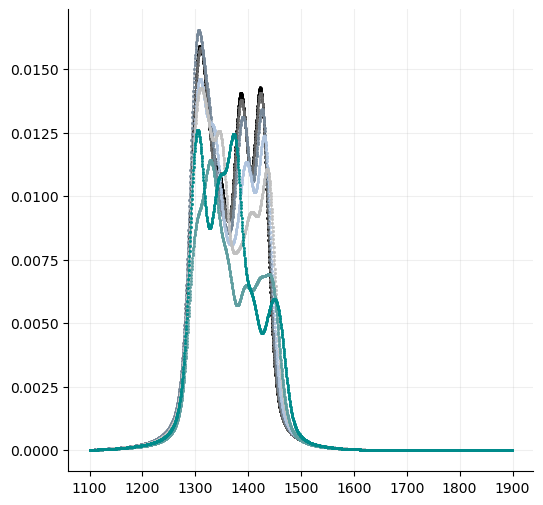

<Figure size 600x600 with 0 Axes>

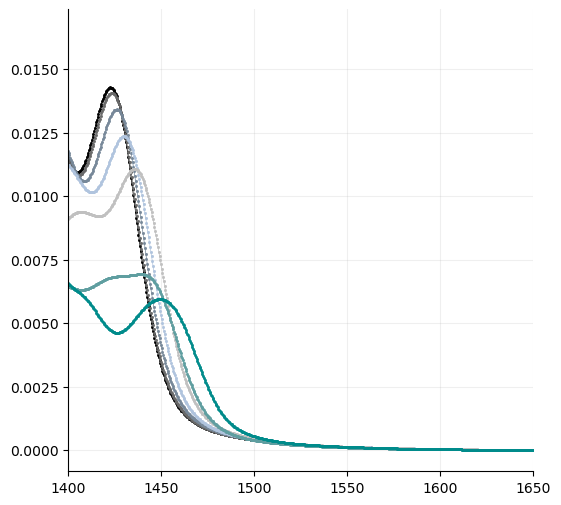

index_1450: 896
index_1650: 1407
1151
0.0016643202640580501
0.2277041337241965 at 1701.9499999999994
0.005876908980032569
1.4146533575244415 at 1701.9499999999994
-0.0068372045708846585
5.0498866726350125 at 1707.4099999999976
0.015189296237383187
17.054601269933965 at 1715.9899999999948
-0.19892909666196257
30.49551105937872 at 1736.2699999999882
-0.031082377843891118
54.99173665779948 at 1769.4199999999773


C:\Users\jmcc0\AppData\Local\Temp\ipykernel_1616\341037560.py:68: RuntimeWarning: divide by zero encountered in divide
  FOM[i-1] = results[i]/results[0]-1
C:\Users\jmcc0\AppData\Local\Temp\ipykernel_1616\341037560.py:68: RuntimeWarning: invalid value encountered in divide
  FOM[i-1] = results[i]/results[0]-1


IndexError: list index out of range

In [48]:
        PLOT_LIMIT=[1400,1600]
        i=0
        data = []
        legend = []

        x_array, y_array_in = read_in("absorption_{}.txt".format(i))

        num_discrete = 1024 # Base 2 for FFT
        func_x = np.zeros(num_discrete)
        Gauss_y = np.zeros(num_discrete)
        Lorentz_y = np.zeros(num_discrete)
        x_0 = (x_array[len(x_array)-1]+x_array[0])/2
        print(x_0)
        gamma = 15

        sigma = 10

        for i in range(num_discrete):
            func_x[i] = x_array[i]
            Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
            Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

        Gauss_y = Gauss_y/abs(sum(Gauss_y))
        Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
        WL_xaxis = np.zeros(num_discrete)
        WL_axis_new = pad_func_linear(x_array) # for plotting
        Lorentz_y_new = pad_func_zeros(Lorentz_y)
        Gauss_y_new = pad_func_zeros(Gauss_y)
        voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
        func_x_new = pad_func_linear(func_x)
        #N_V = abs(max(voigt_y))
        #voigt_y /= N_V
        results=[]

        for i in range(0,num_electric_fields):
            y_array_in=[]
            x_array, y_array_in = read_in("absorption_{}.txt".format(i))
            y_array = pad_func_zeros(y_array_in)
            absorption = convolve(voigt_y, y_array)
            results.append(absorption)


        PLOT_LIMIT=[]
        plot_graphs(func_x_new, results)
        PLOT_LIMIT=[1400,1650]
        plot_graphs(func_x_new, results)

        PLOT_LIMIT=[]
        Y_LIMIT = []
        LEGEND=False
        label_x = ""
        label_y = ""
        plot_title = ""
        #plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])
        PLOT_LIMIT=[]

        FOM = np.zeros((8,2*num_discrete))
        FOM_1550 = np.zeros((8))
        max_FOM = np.zeros((8))
        index_1550 = np.abs(func_x_new - 1550).argmin()
        index_1450 = np.abs(func_x_new - 1450).argmin()
        index_1650 = np.abs(func_x_new - 1650).argmin()

        print("index_1450:", index_1450)
        print("index_1650:", index_1650)
        print(index_1550)
        for i in range(1,9):
            FOM[i-1] = results[i]/results[0]-1
            FOM_1550[i-1] = FOM[i-1][index_1550]
            print(FOM_1550[i-1])
            max_FOM[i-1] = max(FOM[i-1][j] for j in range(index_1450,index_1650))
            index = np.abs(FOM[i-1] - max_FOM[i-1]).argmin()
            max_FOM_WL = func_x_new[index]
            print(str(max_FOM[i-1])+" at "+str(max_FOM_WL))

        dn_dE = (max_FOM[2]-max_FOM[1])/(3-2) # AU/(V/um)
        MAX_FOM=max(FOM_1550)
        
        
        FOM_data = [MAX_FOM, dn_dE]

        print("\n")
        print(dn_dE)
        print(MAX_FOM)

        Y_LIMIT = [0,10]
        plot_graphs(func_x_new, FOM)
        Y_LIMIT=[]

        input_file = "input.txt"
        materials_file = "materials.txt"
        simulation_params_file = "simulation_parameters.txt"
        layers = parse_input_file(input_file)
        materials = parse_materials_file(materials_file)

        qwi_target_shift, num_electric_fields, efield = parse_simulation_parameters_file(simulation_params_file)
        print("Layers:", layers)
        print("Materials:", materials)
        print("QWI Target Shift:", qwi_target_shift)
        print("Number of Electric Fields:", num_electric_fields)
        print("Max Applied Electric Field:", max_electric_field)
        print("FOM:", FOM_data)
        input_=[materials,layers,qwi_target_shift,max_electric_field] 
        #input_features_matrix.append(input_)
        figure_of_merit = np.append(FOM_data[0],FOM_data[1]) # result is max(FOM)


In [204]:
# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.067, 0.08, 0.50, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.12, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.025, 0.40, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []

layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer7 = Layer(AlAs, 50)

layer22 = Layer(InGaAlAs_material(20000.81), 30)
layer222 = Layer(InGaAlAs_material(20000.81), 60)
layer2 = Layer(InGaAlAs_material(1549.81), 40)
layer3 = Layer(InGaAlAs_material(1450), 140)
layer5 = Layer(InGaAlAs_material(1700), 67)
layer6 = Layer(InGaAlAs_material(1000), 30)
layer4 = Layer(InGaAlAs_material(1350), 30)
layer42 = Layer(InGaAlAs_material(1250), 30)
InP_layer2 = Layer(InGaAlAs_material(1239.85), 100)
InP_layer3 = Layer(InGaAlAs_material(900), 100)
layer3 = Layer(InGaAlAs_material(1450.81), 50)
InP_layer = Layer(InGaAlAs_material(1229.85), 50)
layer9 = Layer(InGaAlAs_material(1003.5), 30)
layer10 = Layer(InGaAlAs_material(1350), 30)
# layers = [InP_layer2, layer3,  InP_layer2]

# layers = [InP_layer2, layer9, layer22, layer9, layer22,  layer42, layer222, InP_layer2]
layers = [InP_layer2, layer22, layer3, layer2, InP_layer2]

print("Initial Bandgap: " + str(getGap(layers)))

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

        
num_electric_fields = 6 # simulation cxx - not python
max_electric_field = 11
wavelength_shift = 30 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
#subprocess.run(['simulation_multithread.exe'])

x = 0.468033
y = -1.11468e-15
0.7499006886428017
x = 0.468033
y = -1.11468e-15
0.7499006886428017
x = 0.423062
y = 0.0457264
0.8000976225011801
x = 0.377741
y = 0.0918103
0.8551726318209304
x = 0.468033
y = -1.11468e-15
0.7499006886428017
x = 0.127191
y = 0.346573
1.239998987280111
x = 0.329646
y = 0.140714
0.9185184364308158
x = 0.278092
y = 0.193135
0.9919997695407117
x = 0.27263
y = 0.198688
1.0001199377038916
x = 0.0540141
y = 0.420981
1.3777774057846741
x = 0.378118
y = 0.0914263
0.8546945082562576
x = 0.267205
y = 0.204205
1.0082528138747606
x = 0.129591
y = 0.344134
1.2356765885725054
x = 0.329646
y = 0.140714
0.9185184364308158
Initial Bandgap: 1471.2931717758509


In [158]:
num_electric_fields = 6 # simulation cxx - not python
max_electric_field = 8
wavelength_shift = 0 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)

In [198]:
#layers, check = findAlloys(layers, 1550)

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")
        
num_electric_fields = 15 # simulation cxx - not python
max_electric_field = 8
wavelength_shift = 0 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
# FOM_DATA_QWI_x.append(wavelength_shift)
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
subprocess.run(['simulation_multithread_2.exe'])

AttributeError: 'str' object has no attribute 'name'

1500.0


<Figure size 600x600 with 0 Axes>

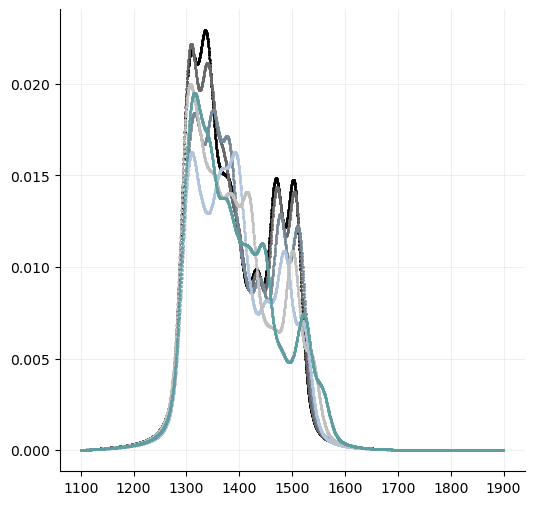

<Figure size 600x600 with 0 Axes>

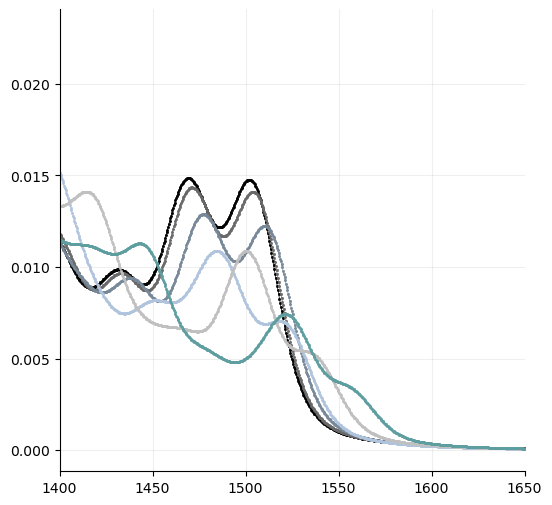

index_1450: 896
index_1650: 1407
1151
0.04624284061189399
0.11856592487309436 at 1795.5499999999688
0.2539863333311314
0.5959185267127642 at 1805.6899999999655
0.44346726055560826
0.8758876844225163 at 1803.7399999999661
2.1647667484123985
2.2829543656214537 at 1545.94
2.669713060104291
3.528331718504772 at 1560.8


C:\Users\jmcc0\AppData\Local\Temp\ipykernel_13616\1693366945.py:68: RuntimeWarning: divide by zero encountered in divide
  FOM[i-1] = results[i]/results[0]-1
C:\Users\jmcc0\AppData\Local\Temp\ipykernel_13616\1693366945.py:68: RuntimeWarning: invalid value encountered in divide
  FOM[i-1] = results[i]/results[0]-1


IndexError: list index out of range

In [205]:
        PLOT_LIMIT=[1400,1600]
        i=0
        data = []
        legend = []

        x_array, y_array_in = read_in("absorption_{}.txt".format(i))

        num_discrete = 1024 # Base 2 for FFT
        func_x = np.zeros(num_discrete)
        Gauss_y = np.zeros(num_discrete)
        Lorentz_y = np.zeros(num_discrete)
        x_0 = (x_array[len(x_array)-1]+x_array[0])/2
        print(x_0)
        gamma = 15

        sigma = 10

        for i in range(num_discrete):
            func_x[i] = x_array[i]
            Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
            Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

        Gauss_y = Gauss_y/abs(sum(Gauss_y))
        Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
        WL_xaxis = np.zeros(num_discrete)
        WL_axis_new = pad_func_linear(x_array) # for plotting
        Lorentz_y_new = pad_func_zeros(Lorentz_y)
        Gauss_y_new = pad_func_zeros(Gauss_y)
        voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
        func_x_new = pad_func_linear(func_x)
        #N_V = abs(max(voigt_y))
        #voigt_y /= N_V
        results=[]

        for i in range(0,num_electric_fields):
            y_array_in=[]
            x_array, y_array_in = read_in("absorption_{}.txt".format(i))
            y_array = pad_func_zeros(y_array_in)
            absorption = convolve(voigt_y, y_array)
            results.append(absorption)


        PLOT_LIMIT=[]
        plot_graphs(func_x_new, results)
        PLOT_LIMIT=[1400,1650]
        plot_graphs(func_x_new, results)

        PLOT_LIMIT=[]
        Y_LIMIT = []
        LEGEND=False
        label_x = ""
        label_y = ""
        plot_title = ""
        #plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])
        PLOT_LIMIT=[]

        FOM = np.zeros((8,2*num_discrete))
        FOM_1550 = np.zeros((8))
        max_FOM = np.zeros((8))
        index_1550 = np.abs(func_x_new - 1550).argmin()
        index_1450 = np.abs(func_x_new - 1450).argmin()
        index_1650 = np.abs(func_x_new - 1650).argmin()

        print("index_1450:", index_1450)
        print("index_1650:", index_1650)
        print(index_1550)
        for i in range(1,9):
            FOM[i-1] = results[i]/results[0]-1
            FOM_1550[i-1] = FOM[i-1][index_1550]
            print(FOM_1550[i-1])
            max_FOM[i-1] = max(FOM[i-1][j] for j in range(index_1450,index_1650))
            index = np.abs(FOM[i-1] - max_FOM[i-1]).argmin()
            max_FOM_WL = func_x_new[index]
            print(str(max_FOM[i-1])+" at "+str(max_FOM_WL))

        dn_dE = (max_FOM[2]-max_FOM[1])/(3-2) # AU/(V/um)
        MAX_FOM=max(FOM_1550)
        
        
        FOM_data = [MAX_FOM, dn_dE]

        print("\n")
        print(dn_dE)
        print(MAX_FOM)

        Y_LIMIT = [0,10]
        PLOt_LIMIT=[1500,1600]
        plot_graphs(func_x_new, FOM)
        Y_LIMIT=[]

        input_file = "input.txt"
        materials_file = "materials.txt"
        simulation_params_file = "simulation_parameters.txt"
        layers = parse_input_file(input_file)
        materials = parse_materials_file(materials_file)

        qwi_target_shift, num_electric_fields, efield = parse_simulation_parameters_file(simulation_params_file)
        print("Layers:", layers)
        print("Materials:", materials)
        print("QWI Target Shift:", qwi_target_shift)
        print("Number of Electric Fields:", num_electric_fields)
        print("Max Applied Electric Field:", max_electric_field)
        print("FOM:", FOM_data)
        input_=[materials,layers,qwi_target_shift,max_electric_field] 
        #input_features_matrix.append(input_)
        figure_of_merit = np.append(FOM_data[0],FOM_data[1]) # result is max(FOM)


Run:0
1500.0


<Figure size 600x600 with 0 Axes>

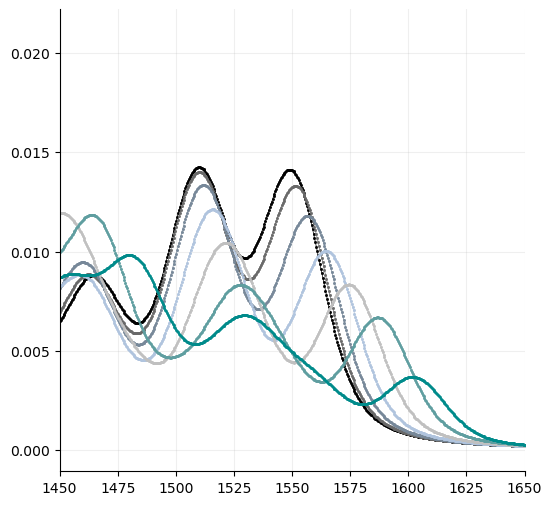

index_1450: 998
index_1650: 1407
1151
0.0 at 1100.0
0.35240073824599283 at 1577.61
1.1307056490015621 at 1581.52
2.4738531214779464 at 1587.39
4.452359508588905 at 1595.99
4.467459363917243 at 1608.9
[ 0.         -0.19573562 -0.4963203  -0.66457164 -0.6286084  -0.62483873
  0.          0.        ]


-0.3005846785032701
0.0
5


<Figure size 600x600 with 0 Axes>

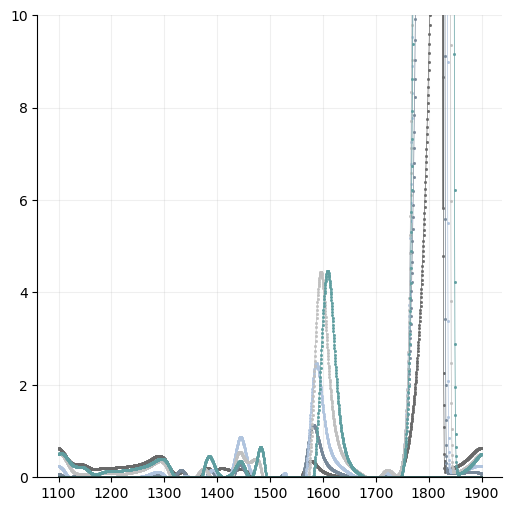

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

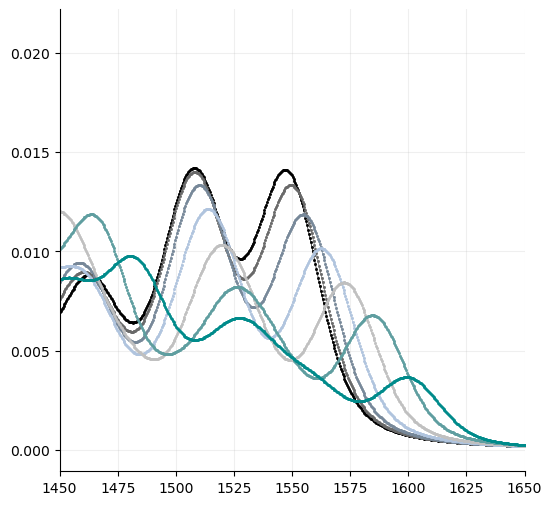

index_1450: 998
index_1650: 1407
1151
0.0 at 1825.1899999999591
0.35425453569404275 at 1575.66
1.1450295074868926 at 1579.57
2.492956400370972 at 1585.43
4.400437362913144 at 1593.65
4.311098222743902 at 1606.55
[ 0.         -0.15643942 -0.45079807 -0.65893577 -0.6472542  -0.64925732
  0.          0.        ]


-0.2943586564368148
0.0
4


C:\Users\jmcc0\AppData\Local\Temp\ipykernel_13616\2919925900.py:186: RuntimeWarning: invalid value encountered in divide
  FOM[i-1] = results[i]/results[1]-1
C:\Users\jmcc0\AppData\Local\Temp\ipykernel_13616\2919925900.py:186: RuntimeWarning: divide by zero encountered in divide
  FOM[i-1] = results[i]/results[1]-1


<Figure size 600x600 with 0 Axes>

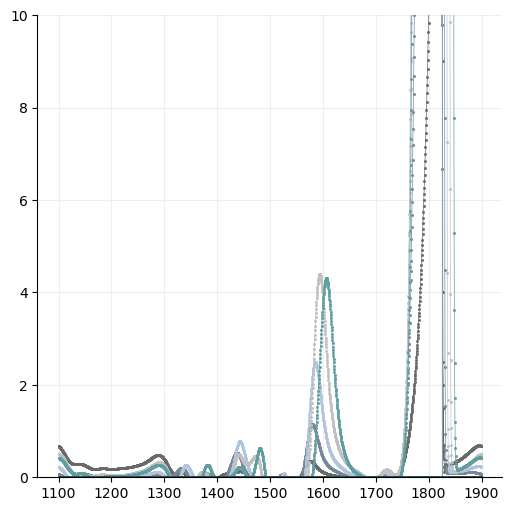

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

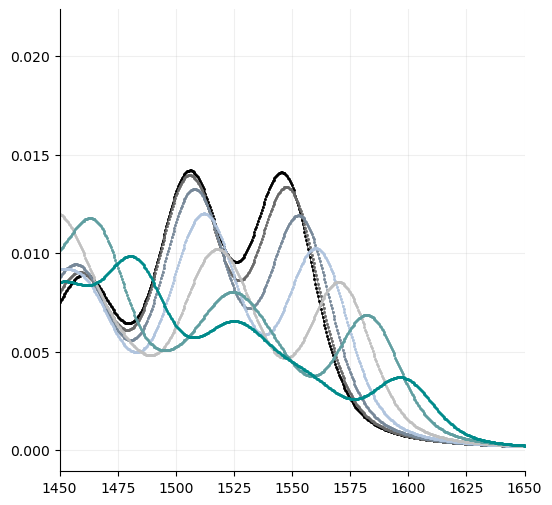

index_1450: 998
index_1650: 1407
1151
0.0 at 1823.2399999999598
0.3584007889937131 at 1573.7
1.0987429932060224 at 1577.61
2.4369973900023996 at 1583.09
4.346288345996861 at 1591.69
4.1701045916955355 at 1603.81
[ 0.         -0.11265483 -0.38005249 -0.63649791 -0.65958076 -0.65825839
  0.          0.        ]


-0.26739766217129657
0.0
4


<Figure size 600x600 with 0 Axes>

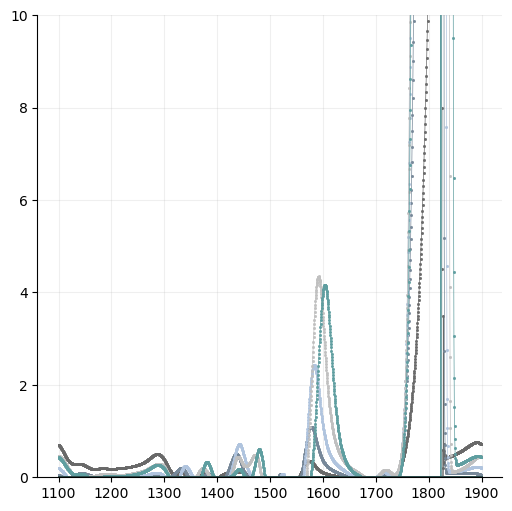

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

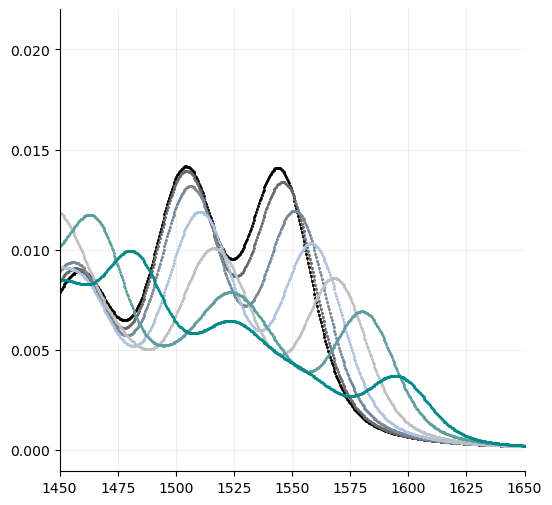

index_1450: 998
index_1650: 1407
1151
0.0 at 1819.339999999961
0.3604946053928224 at 1572.14
1.046459423939222 at 1575.66
2.37063829390186 at 1581.52
4.274484258410929 at 1589.74
4.09577898101283 at 1601.86
[ 0.         -0.07528362 -0.31333613 -0.60291176 -0.65731979 -0.66045947
  0.          0.        ]


-0.23805250834440195
0.0
4


<Figure size 600x600 with 0 Axes>

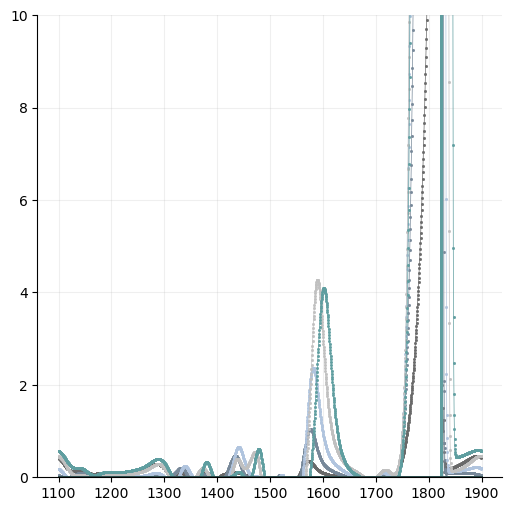

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

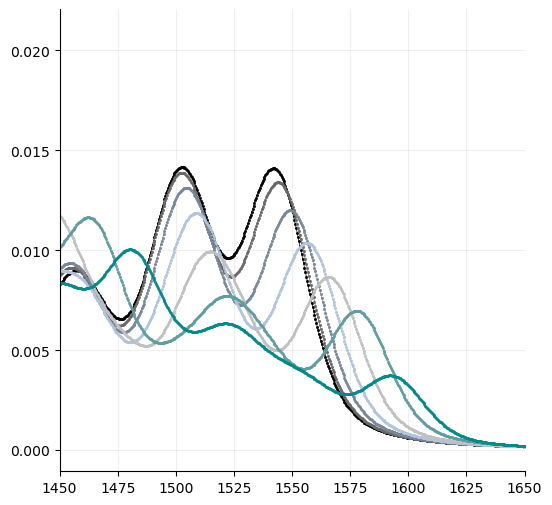

index_1450: 998
index_1650: 1407
1151
0.0 at 1823.2399999999598
0.36398537331783665 at 1824.0199999999595
1.055410974458427 at 1573.7
2.3069605959185733 at 1579.18
4.1983494270694575 at 1587.39
4.084126851310422 at 1599.9
[ 0.         -0.02470271 -0.23027725 -0.54074233 -0.64792784 -0.65408498
  0.          0.        ]


-0.20557454052318302
0.0
4


<Figure size 600x600 with 0 Axes>

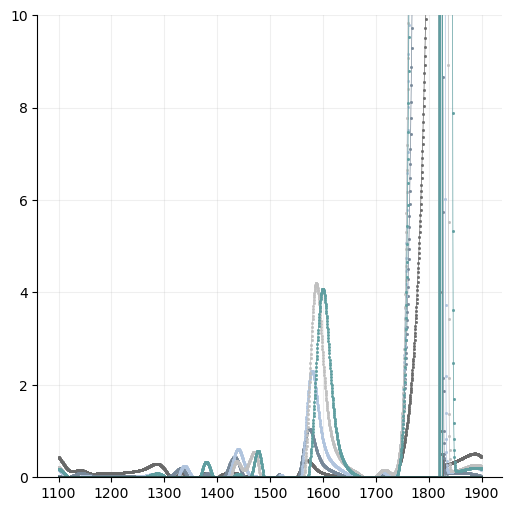

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

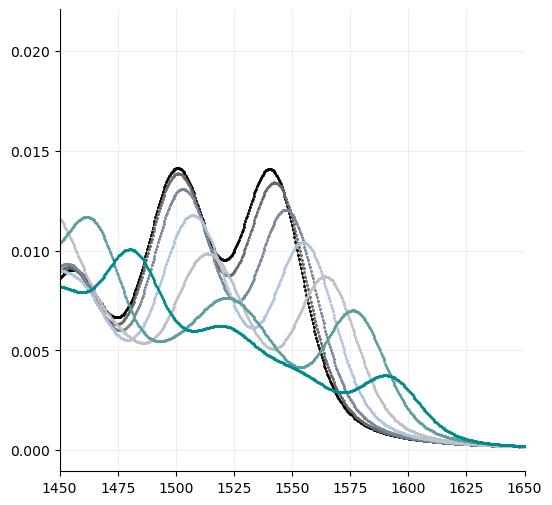

index_1450: 998
index_1650: 1407
1151
0.0 at 1818.5599999999613
0.3246452804861426 at 1568.23
1.0593080649203452 at 1572.14
2.3133832008830013 at 1577.61
4.198358876664971 at 1585.83
4.001480139001617 at 1597.95
[ 0.          0.01331699 -0.15474797 -0.4847022  -0.63198123 -0.64344021
  0.          0.        ]


-0.1680649607840251
0.013316986617548432
4


<Figure size 600x600 with 0 Axes>

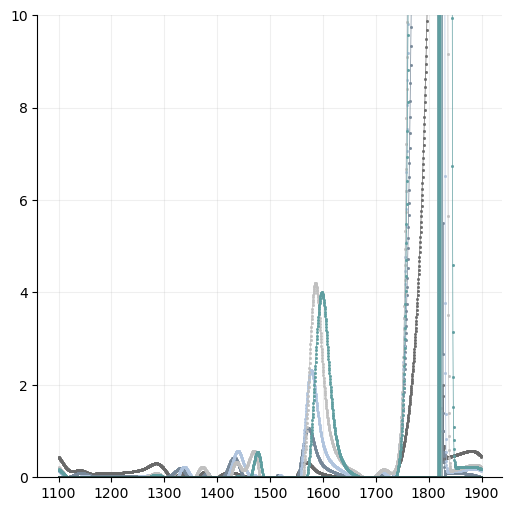

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

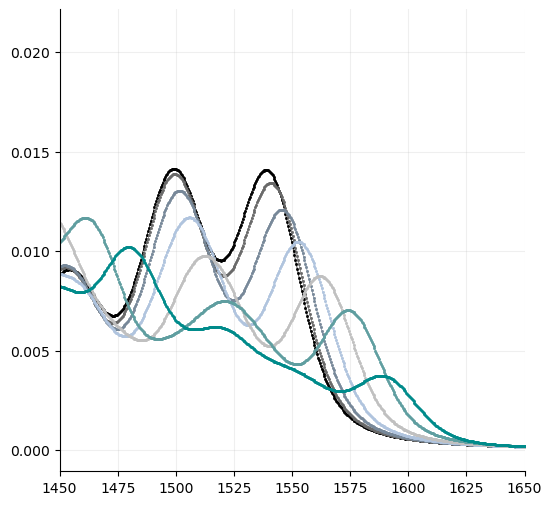

index_1450: 998
index_1650: 1407
1151
0.0 at 1816.9999999999618
0.32679387065138865 at 1566.67
1.0057305454200232 at 1570.58
2.240621518138784 at 1576.05
4.10577144763805 at 1583.87
3.9746827793555477 at 1595.99
[ 0.          0.05286812 -0.06317428 -0.401999   -0.60256077 -0.6265675
  0.          0.        ]


-0.11604239654862958
0.05286812018295883
4


<Figure size 600x600 with 0 Axes>

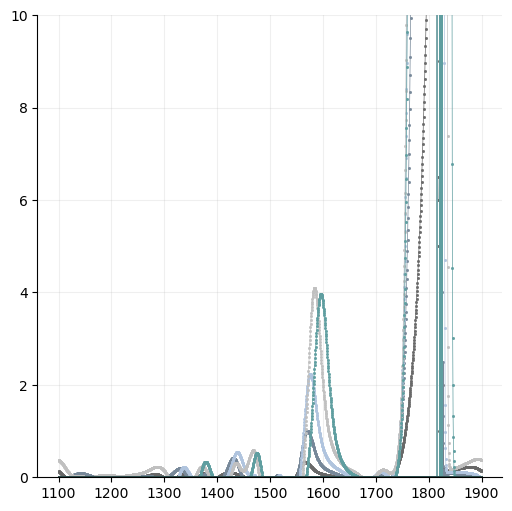

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

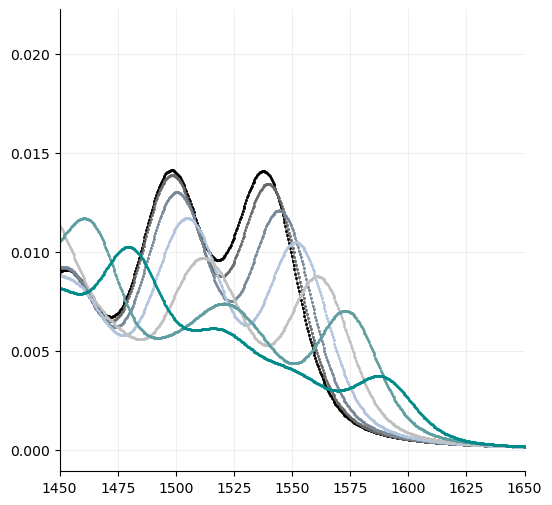

index_1450: 998
index_1650: 1407
1151
0.0 at 1818.1699999999614
0.3274985942385471 at 1818.9499999999612
1.0083208168856772 at 1825.579999999959
2.24375761718929 at 1574.88
4.100731364153219 at 1582.7
3.9536865773441265 at 1594.82
[ 0.          0.08163238  0.00392435 -0.33698087 -0.57752052 -0.60590583
  0.          0.        ]


-0.0777080323782795
0.08163238202569723
4


<Figure size 600x600 with 0 Axes>

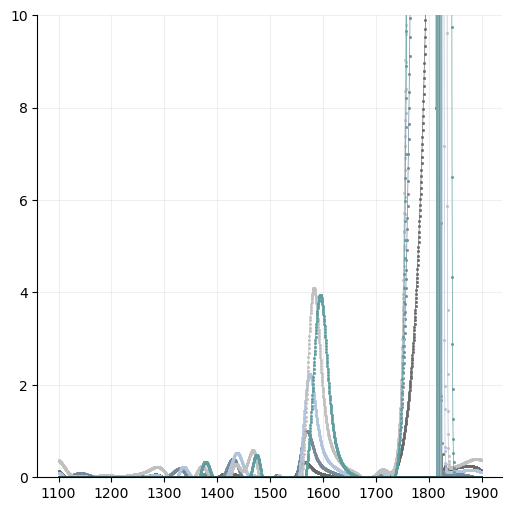

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

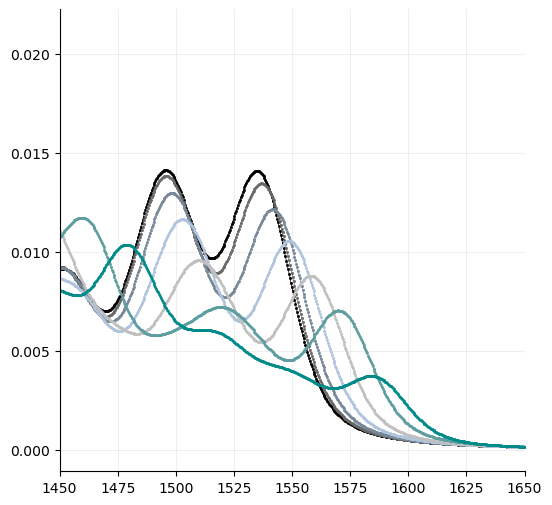

index_1450: 998
index_1650: 1407
1151
0.0 at 1814.6599999999626
0.32963491371594955 at 1825.579999999959
1.0111571978420293 at 1824.4099999999594
2.2414740523909313 at 1571.75
4.072089467765552 at 1579.96
3.8936904270537243 at 1592.08
[ 0.          0.149573    0.17576691 -0.14684625 -0.48986291 -0.55216034
  0.          0.        ]


0.026193910799312325
0.1757669119108951
4


<Figure size 600x600 with 0 Axes>

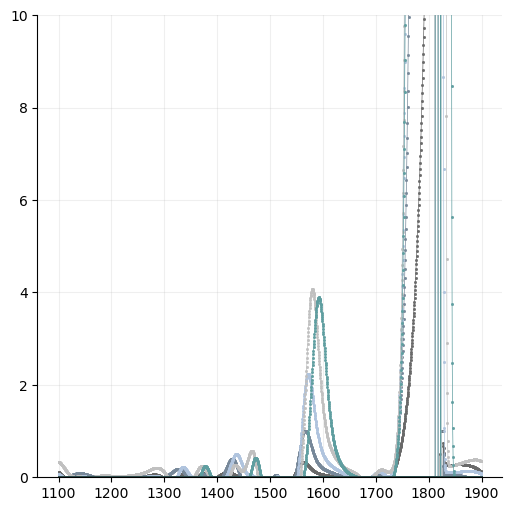

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

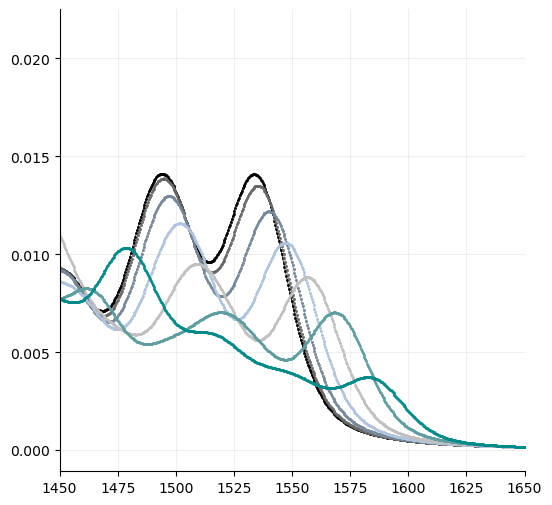

index_1450: 998
index_1650: 1407
1151
0.0 at 1810.7599999999638
0.3292574665110599 at 1815.0499999999624
1.0108934720892018 at 1565.1
2.236979356001921 at 1570.19
4.0257758098960785 at 1578.4
3.8942669736755153 at 1590.91
[ 0.          0.18501706  0.28124754 -0.00900065 -0.42031481 -0.51554241
  0.          0.        ]


0.09623048284646618
0.2812475397938474
4


<Figure size 600x600 with 0 Axes>

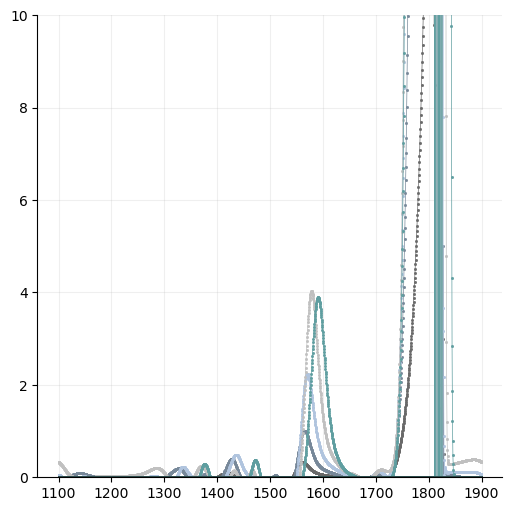

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

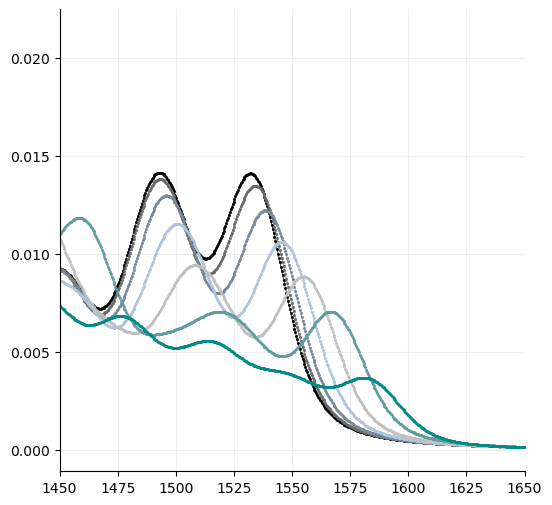

index_1450: 998
index_1650: 1407
1151
0.0 at 1811.1499999999637
0.2913505381726573 at 1819.729999999961
0.9558760205110264 at 1563.54
2.1614815915324437 at 1569.01
3.9464169373079416 at 1576.83
3.774051658848845 at 1589.35
[ 0.          0.18808237  0.35314807  0.11999881 -0.33766332 -0.48450836
  0.          0.        ]


0.1650656960683825
0.3531480707667496
4


<Figure size 600x600 with 0 Axes>

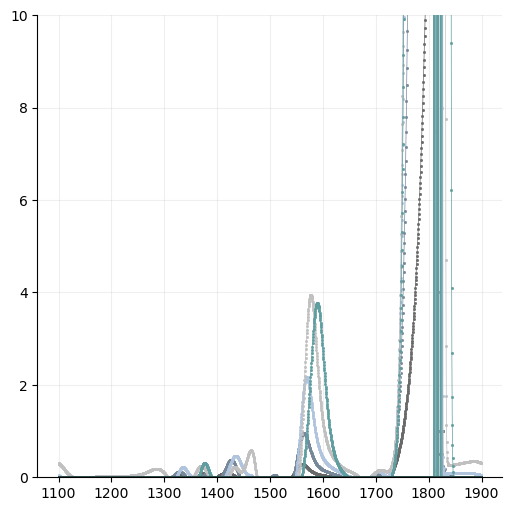

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

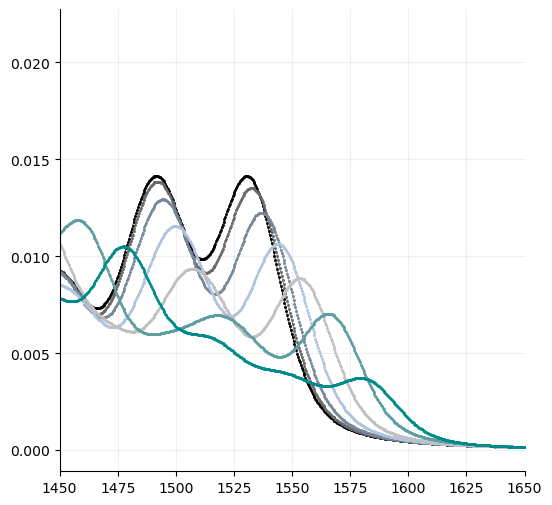

index_1450: 998
index_1650: 1407
1151
0.0 at 1807.6399999999649
0.290531303724453 at 1819.339999999961
0.9544501598231625 at 1819.339999999961
2.1520136760045436 at 1567.45
3.9977616162518483 at 1575.66
3.8243092572481254 at 1588.17
[ 0.          0.21522459  0.45612066  0.28958335 -0.23931109 -0.41937817
  0.          0.        ]


0.24089607318445805
0.456120661727186
4


<Figure size 600x600 with 0 Axes>

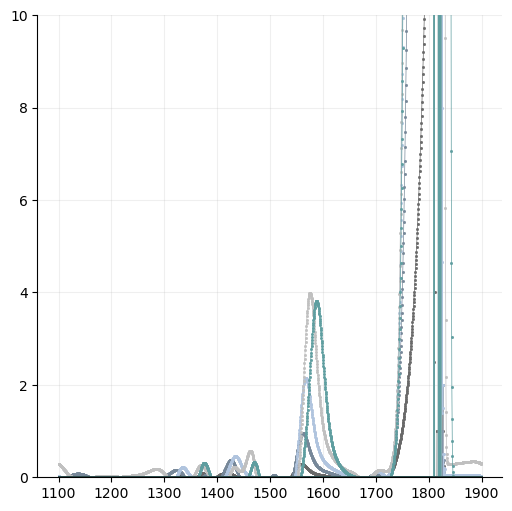

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

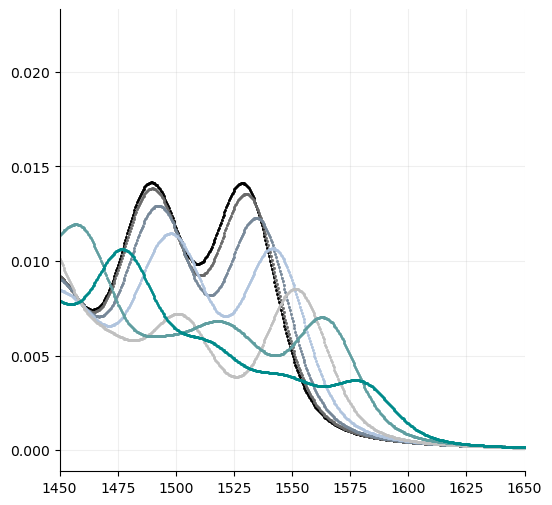

index_1450: 998
index_1650: 1407
1151
0.0 at 1804.9099999999657
0.29103286522336624 at 1824.4099999999594
0.9534045022512152 at 1559.63
2.051368560943912 at 1565.1
3.9480139459453945 at 1573.31
3.8144332475589815 at 1585.83
[ 0.          0.25042267  0.60666462  0.51246821 -0.01834292 -0.30784371
  0.          0.        ]


0.3562419533717822
0.6066646187668292
4


<Figure size 600x600 with 0 Axes>

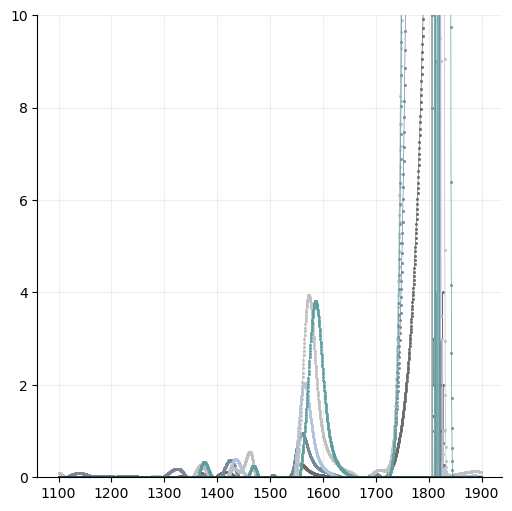

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

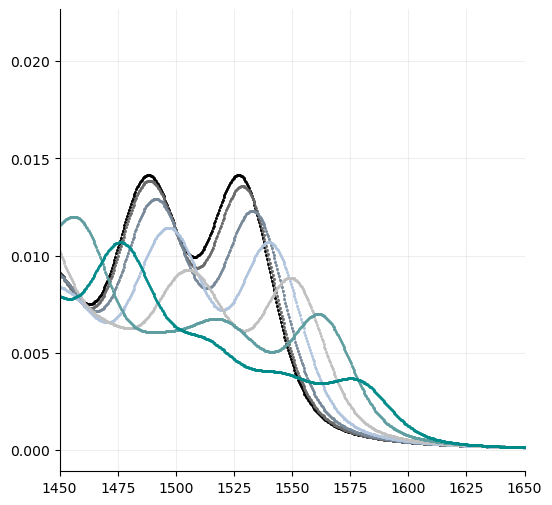

index_1450: 998
index_1650: 1407
1151
0.0 at 1803.3499999999663
0.2905976054493007 at 1823.6299999999596
0.9506989703398372 at 1558.06
2.130415091092611 at 1824.0199999999595
3.898495079090795 at 1571.75
3.7521567523981467 at 1584.26
[ 0.          0.26783406  0.69727452  0.78941304  0.15752923 -0.22245843
  0.          0.        ]


0.4294404594811705
0.789413035318137
4


<Figure size 600x600 with 0 Axes>

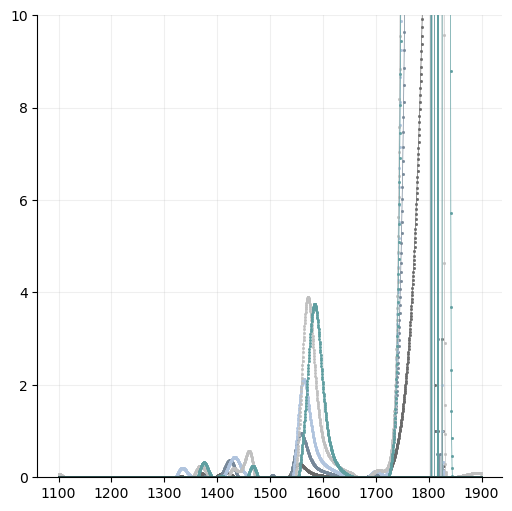

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

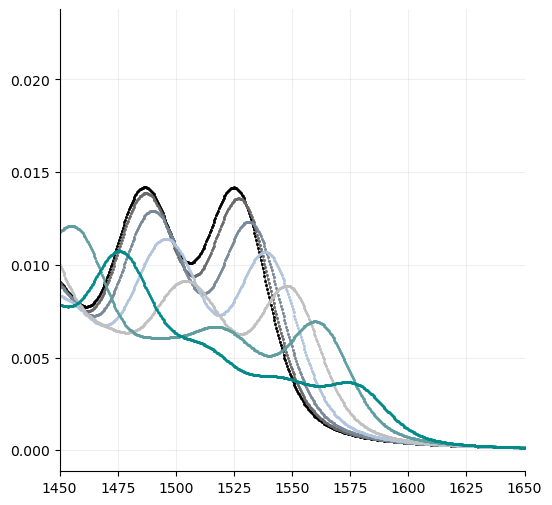

index_1450: 998
index_1650: 1407
1151
0.0 at 1802.1799999999666
0.29151007620639824 at 1818.5599999999613
0.9473744260398484 at 1818.5599999999613
2.121522211677936 at 1825.9699999999589
3.9311204429069173 at 1570.19
3.750761052958824 at 1583.09
[ 0.          0.28146396  0.77739472  1.00801912  0.35375504 -0.12760847
  0.          0.        ]


0.49593075417504484
1.008019118350961
4


<Figure size 600x600 with 0 Axes>

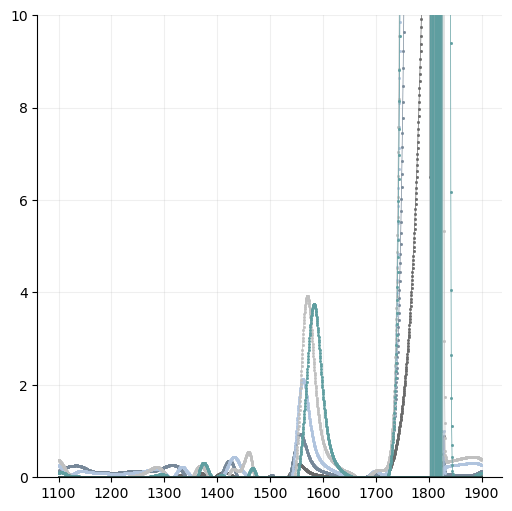

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

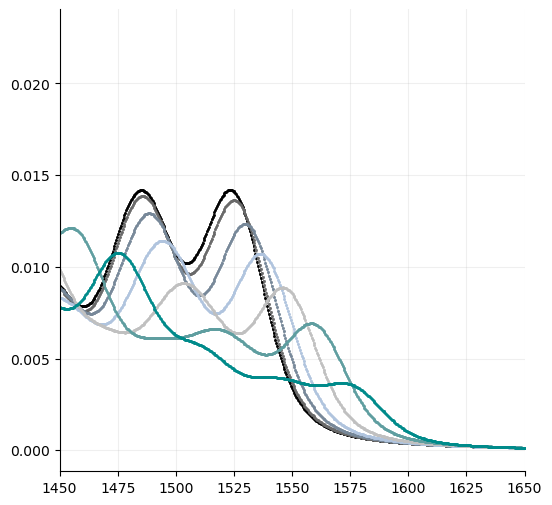

index_1450: 998
index_1650: 1407
1151
0.0 at 1804.9099999999657
0.329389248403404 at 1804.9099999999657
0.9422086818347766 at 1816.9999999999618
2.1804083477427754 at 1821.6799999999603
3.948691652312754 at 1568.62
3.736215201334857 at 1581.13
[0.         0.32752034 0.85615009 1.29203766 0.65269411 0.02223779
 0.         0.        ]


0.5286297526217678
1.292037664768337
4


<Figure size 600x600 with 0 Axes>

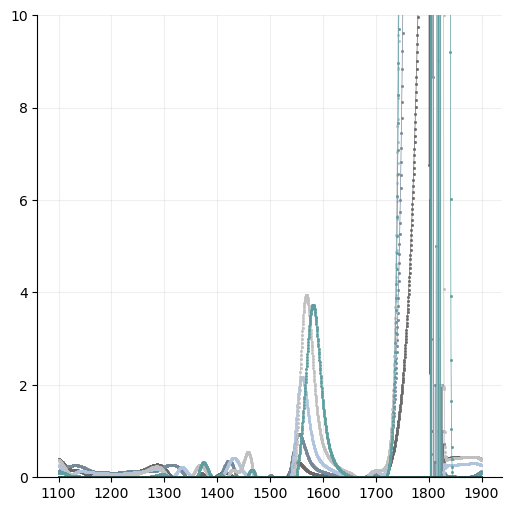

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

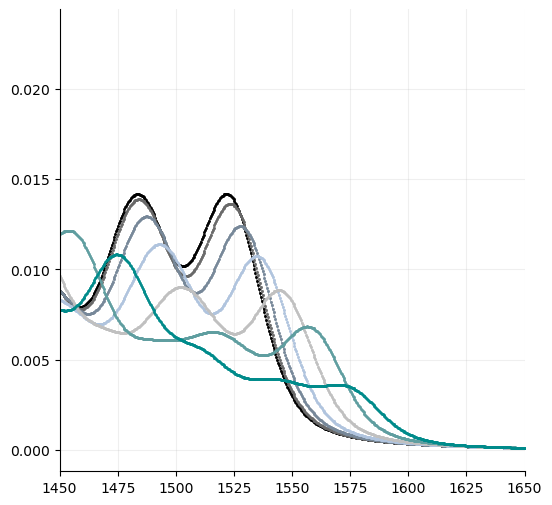

index_1450: 998
index_1650: 1407
1151
0.0 at 1800.2299999999673
0.2905364099100436 at 1804.5199999999659
0.9419769751603255 at 1810.7599999999638
2.165259073154376 at 1558.46
3.8675518696378877 at 1567.06
3.713139386273305 at 1579.96
[0.         0.29033313 0.90302514 1.50181349 0.92672259 0.14790688
 0.         0.        ]


0.6126920144871941
1.5018134921900814
4


<Figure size 600x600 with 0 Axes>

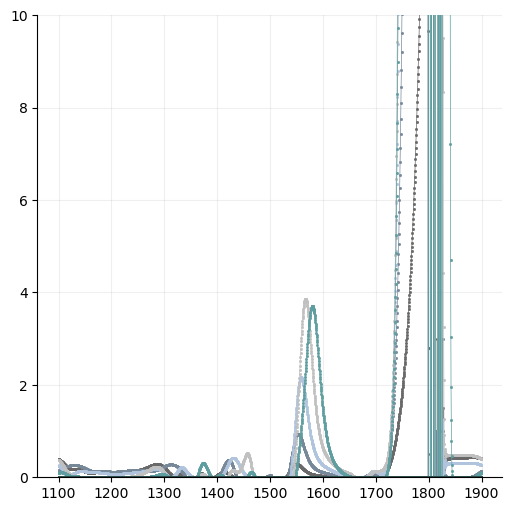

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

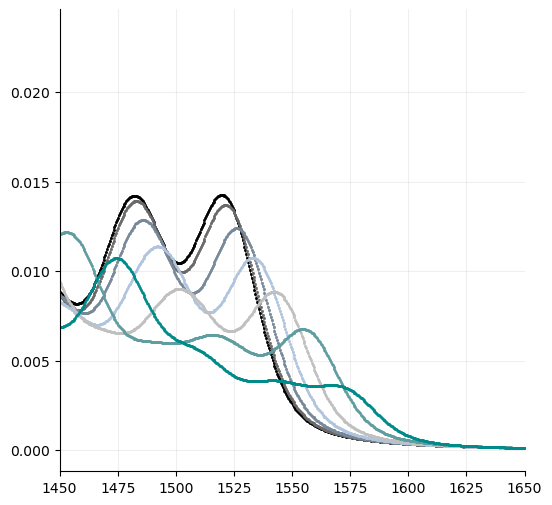

index_1450: 998
index_1650: 1407
1151
0.0 at 1800.2299999999673
0.3275230245666638 at 1804.129999999966
0.9909841903969234 at 1809.979999999964
2.1424071056539535 at 1816.9999999999618
3.8417493355315147 at 1565.1
3.681106625748156 at 1578.01
[0.         0.32180516 0.98311272 1.73266614 1.2902981  0.32878753
 0.         0.        ]


0.6613075632827614
1.7326661352408017
4


<Figure size 600x600 with 0 Axes>

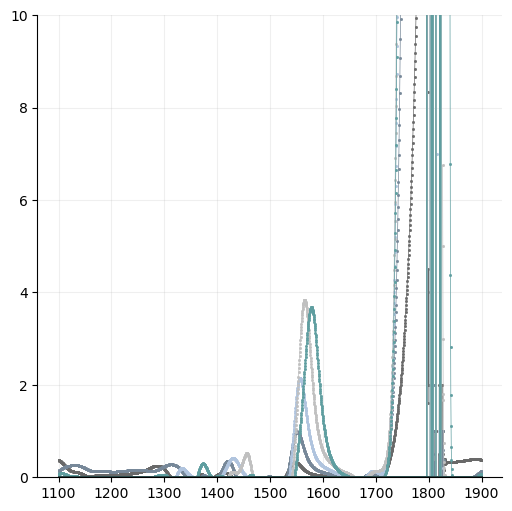

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

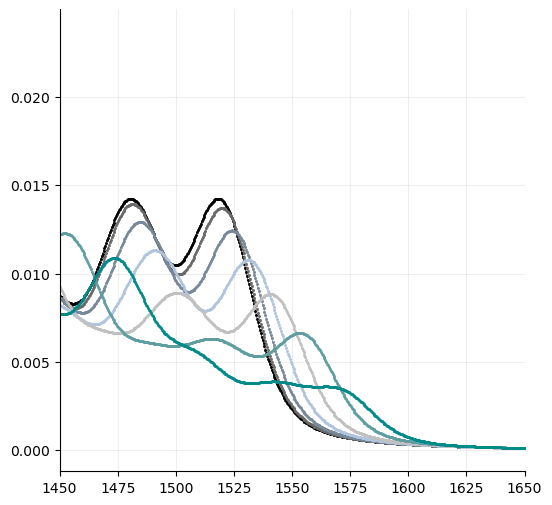

index_1450: 998
index_1650: 1407
1151
0.0 at 1797.889999999968
0.28798198029506117 at 1799.4499999999675
0.9319590333658805 at 1809.1999999999643
2.12374578535469 at 1822.45999999996
3.793357237934913 at 1563.93
3.655104885050279 at 1576.83
[0.         0.27305405 0.9314769  1.87948737 1.58069192 0.49516623
 0.         0.        ]


0.6584228457924095
1.8794873657306557
4


<Figure size 600x600 with 0 Axes>

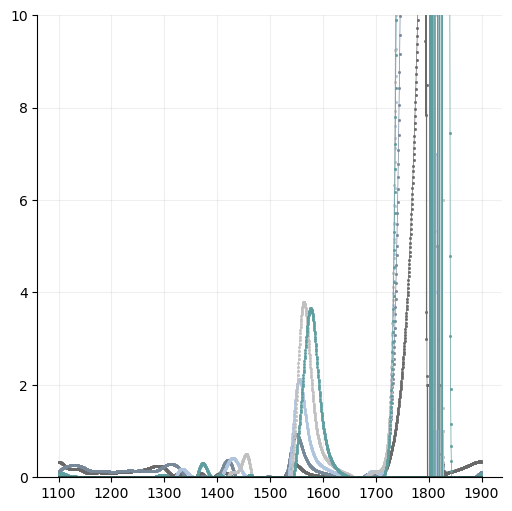

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

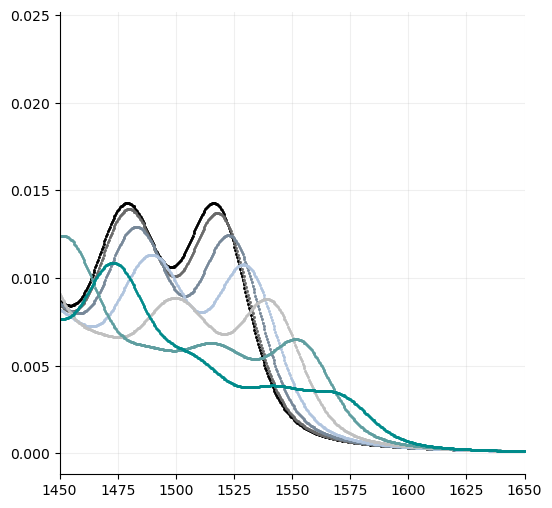

index_1450: 998
index_1650: 1407
1151
0.0 at 1799.0599999999677
0.3306453594964722 at 1808.8099999999645
0.9339050913930049 at 1803.3499999999663
2.1886841828936014 at 1815.4399999999623
3.732707262749713 at 1561.97
3.6599714815892224 at 1575.27
[0.         0.29794165 0.91503016 2.07692851 1.96820936 0.7110468
 0.         0.        ]


0.6170885060481481
2.076928512883571
4


<Figure size 600x600 with 0 Axes>

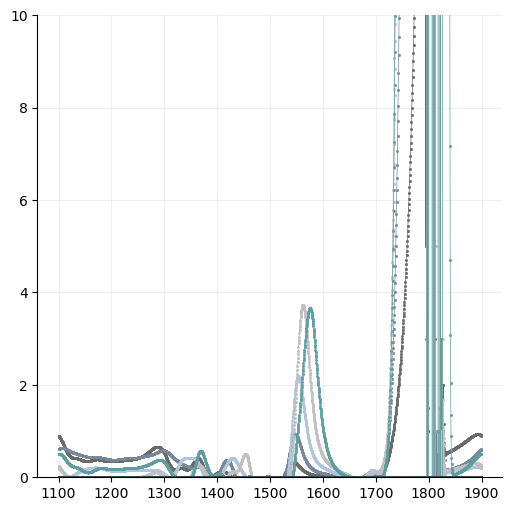

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

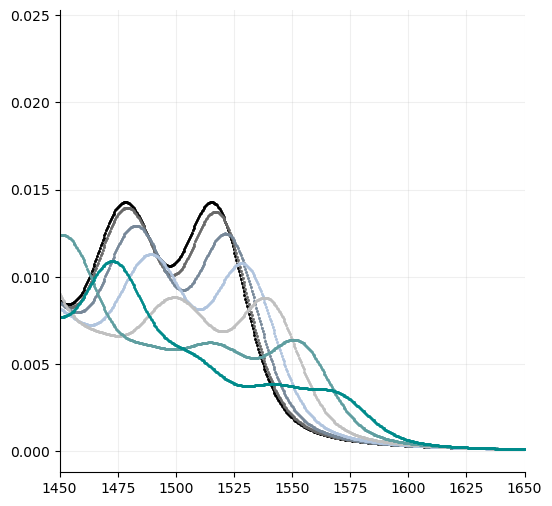

index_1450: 998
index_1650: 1407
1151
0.0 at 1792.03999999997
0.2871949057913612 at 1801.7899999999668
0.9239588464944013 at 1804.9099999999657
2.16462001717066 at 1825.579999999959
3.6777085558476603 at 1561.58
3.6111817530569397 at 1574.49
[0.         0.24885769 0.89067027 2.09841934 2.0744685  0.79117015
 0.         0.        ]


0.641812584349543
2.0984193380644047
4


<Figure size 600x600 with 0 Axes>

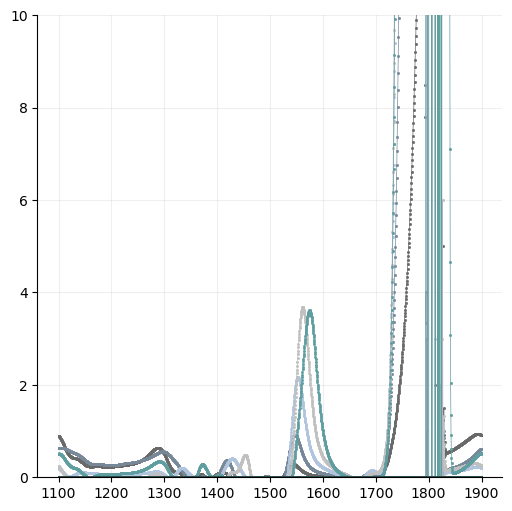

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

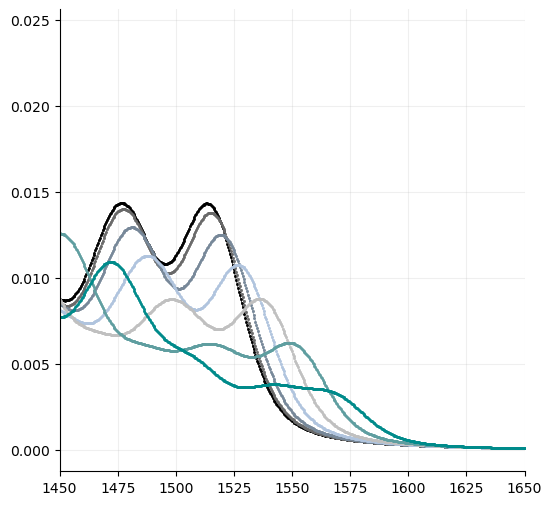

index_1450: 998
index_1650: 1407
1151
0.0 at 1791.2599999999702
0.2854882294151089 at 1795.9399999999687
0.9705405736908546 at 1813.099999999963
2.1375321481190515 at 1812.7099999999632
3.5551840311269904 at 1559.63
3.6211918041800244 at 1572.92
[0.         0.22685131 0.88960578 2.13309443 2.39801846 1.0323717
 0.         0.        ]


0.6627544680127031
2.398018458798781
5


<Figure size 600x600 with 0 Axes>

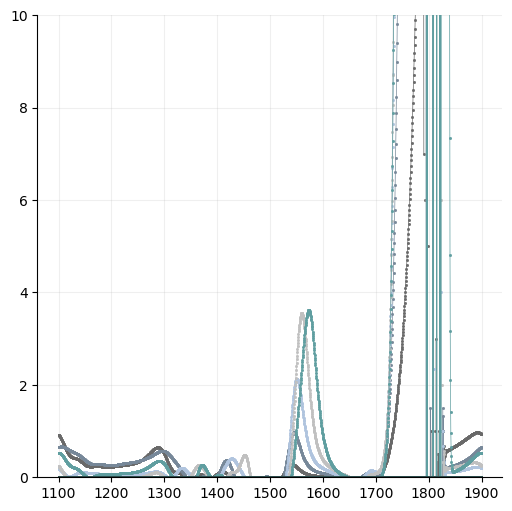

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

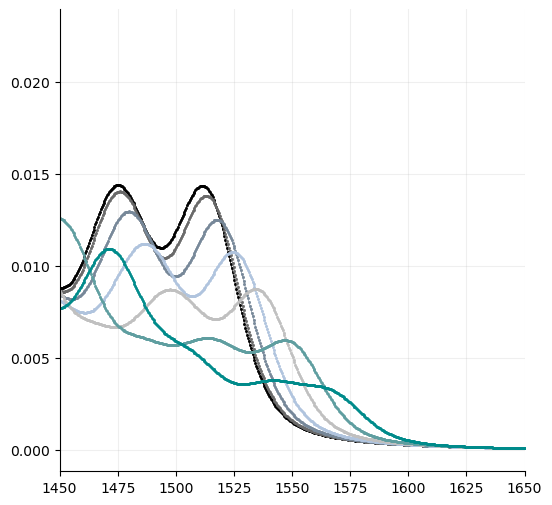

index_1450: 998
index_1650: 1407
1151
0.0 at 1788.529999999971
0.32305551371152297 at 1806.0799999999654
0.9630130028456743 at 1806.4699999999652
2.1811832381057017 at 1810.369999999964
3.411328289051905 at 1825.9699999999589
3.6025093141269524 at 1571.75
[0.         0.23499273 0.81679448 2.17206807 2.61165017 1.26380827
 0.         0.        ]


0.5818017490912346
2.611650172378832
5


<Figure size 600x600 with 0 Axes>

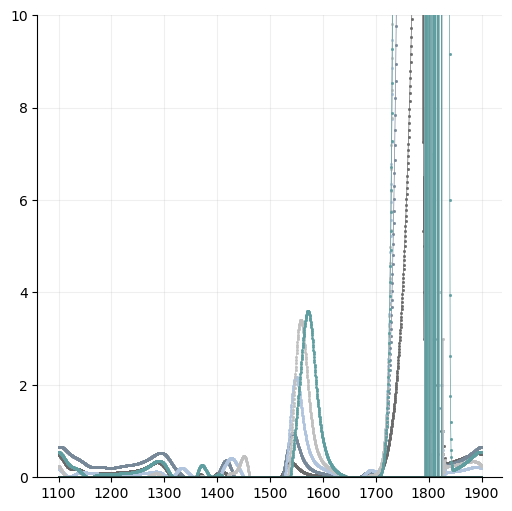

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

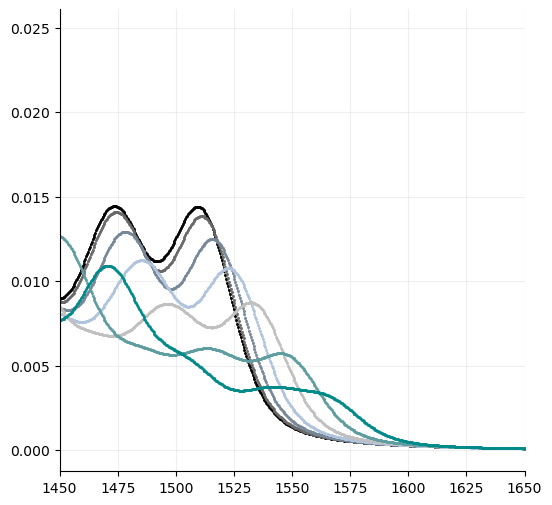

index_1450: 998
index_1650: 1407
1151
0.0 at 1788.529999999971
0.31670802461577274 at 1803.7399999999661
0.9541622994223617 at 1803.7399999999661
2.1498534183220332 at 1814.6599999999626
3.2985164536297056 at 1824.4099999999594
3.5929940578000847 at 1570.19
[0.         0.20136332 0.73497128 2.07575796 2.77536632 1.50561715
 0.         0.        ]


0.5336079515474008
2.7753663152537835
5


<Figure size 600x600 with 0 Axes>

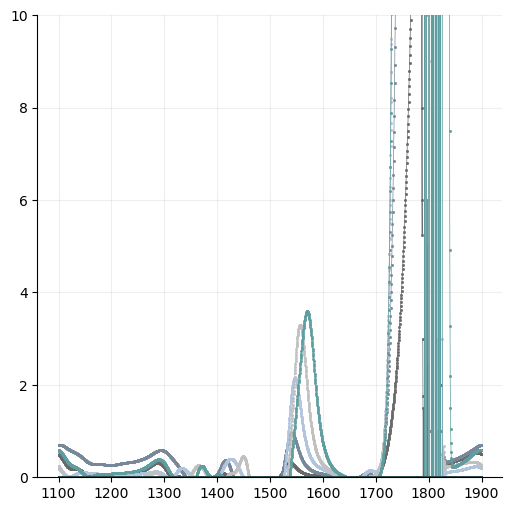

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

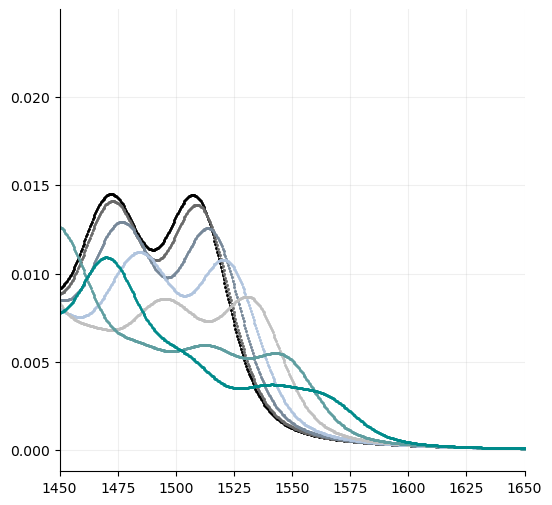

index_1450: 998
index_1650: 1407
1151
0.0 at 1812.7099999999632
0.31948997002820256 at 1823.6299999999596
0.9456883025994895 at 1817.3899999999617
2.1873959950348163 at 1823.6299999999596
3.1312656654924647 at 1822.0699999999601
3.5523977836427783 at 1568.62
[0.         0.18636333 0.65260353 2.01048263 2.85159116 1.72044116
 0.         0.        ]


0.46624020012582323
2.8515911634614852
5


<Figure size 600x600 with 0 Axes>

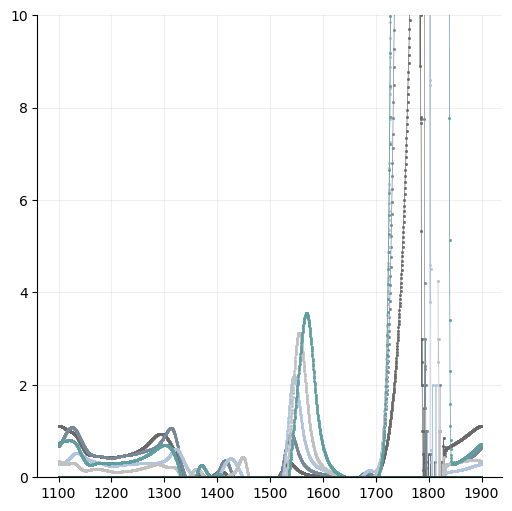

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

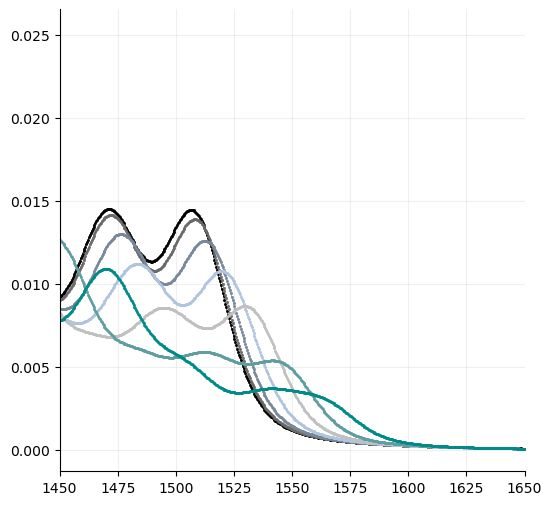

index_1450: 998
index_1650: 1407
1151
0.0 at 1786.5799999999717
0.28074206988153483 at 1820.1199999999608
0.9418109038271458 at 1795.9399999999687
2.1702160388445004 at 1819.729999999961
3.0254920263957272 at 1554.15
3.504047757860403 at 1567.84
[0.         0.15467364 0.6199239  1.93881798 2.83280027 1.83170609
 0.         0.        ]


0.4652502562954228
2.832800266724992
5


<Figure size 600x600 with 0 Axes>

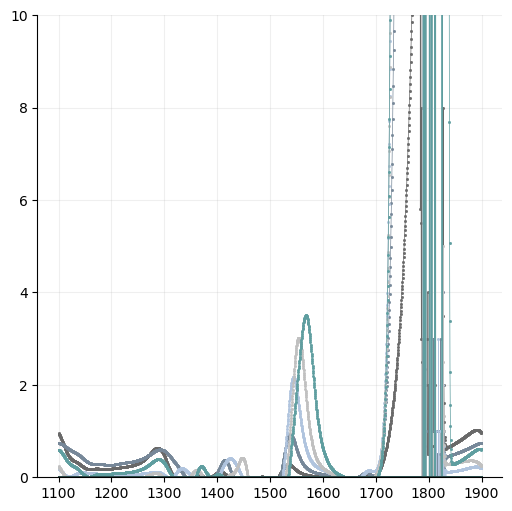

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

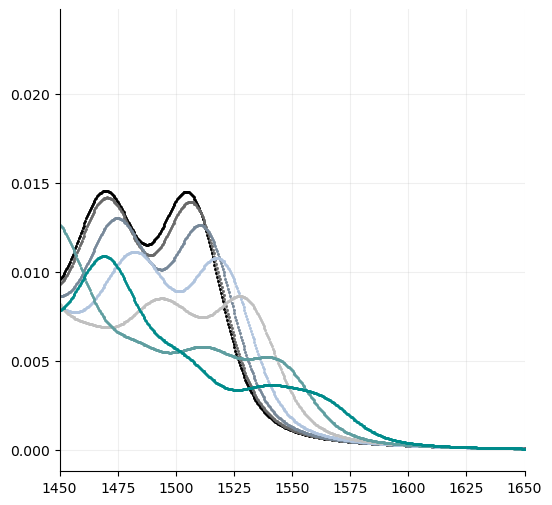

index_1450: 998
index_1650: 1407
1151
0.0 at 1784.6299999999724
0.27870064659130933 at 1793.9899999999693
0.9324045312196079 at 1797.4999999999682
2.1331027381176395 at 1805.6899999999655
2.931162181927799 at 1825.9699999999589
3.5036311280353063 at 1566.67
[0.         0.1360629  0.5423544  1.74763232 2.85730434 2.03559666
 0.         0.        ]


0.4062914980296193
2.857304335143927
5


<Figure size 600x600 with 0 Axes>

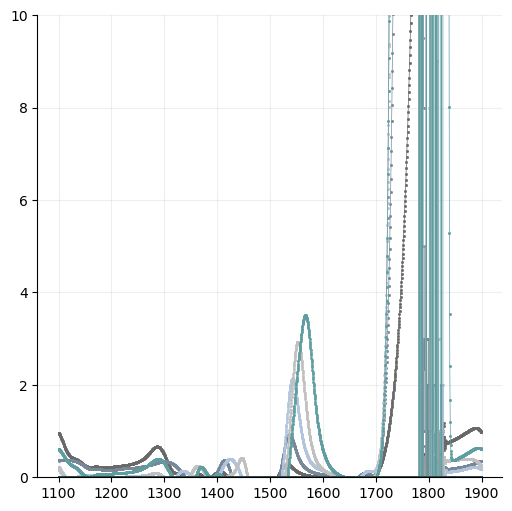

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

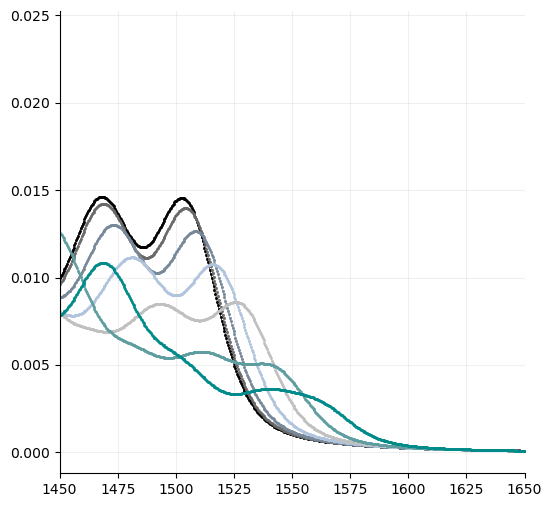

index_1450: 998
index_1650: 1407
1151
0.0 at 1780.3399999999738
0.2763866475645149 at 1801.7899999999668
0.9752728911452857 at 1795.9399999999687
2.1635655590470337 at 1806.859999999965
2.8496567567215814 at 1819.729999999961
3.4559453657267207 at 1565.1
[0.         0.11989384 0.5062099  1.6192507  2.83697565 2.24369805
 0.         0.        ]


0.38631605330480334
2.836975652529628
5


<Figure size 600x600 with 0 Axes>

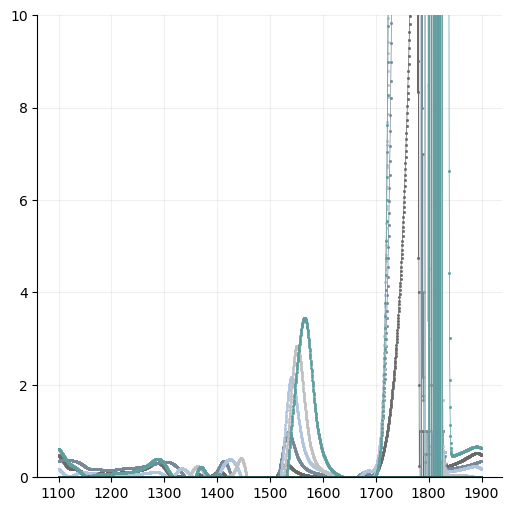

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

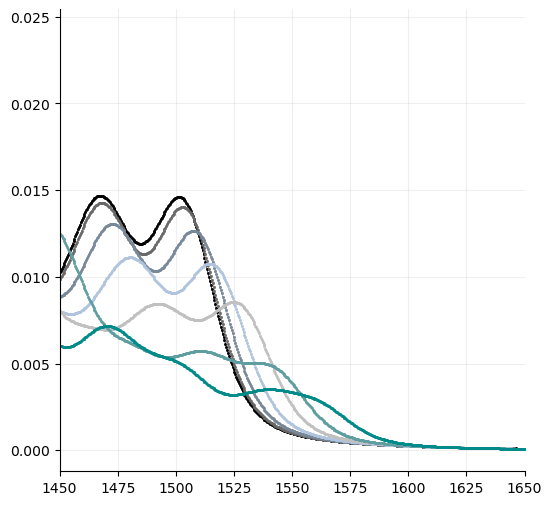

index_1450: 998
index_1650: 1407
1151
0.0 at 1781.1199999999735
0.31349103057467165 at 1800.2299999999673
0.9675705076444192 at 1809.5899999999642
2.2074686466073423 at 1808.8099999999645
2.820971029412963 at 1824.4099999999594
3.3840715003548585 at 1564.32
[0.         0.12964883 0.46338888 1.56508785 2.82078847 2.28226374
 0.         0.        ]


0.3337400505940924
2.820788468068009
5


<Figure size 600x600 with 0 Axes>

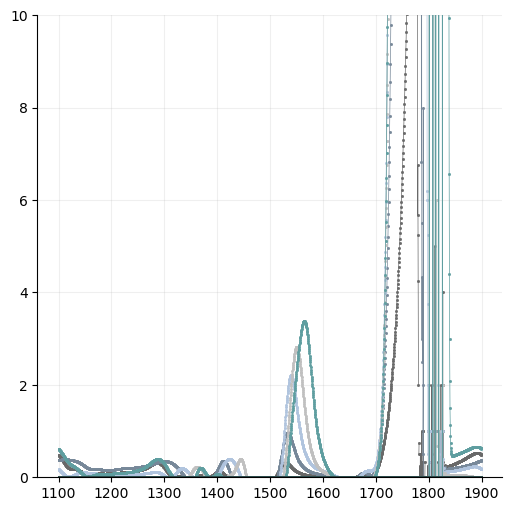

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

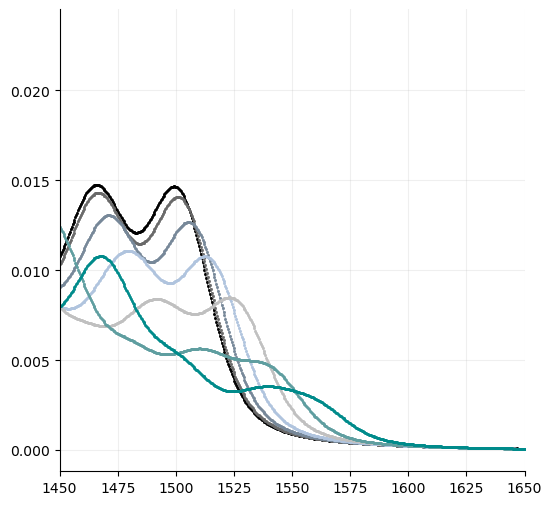

index_1450: 998
index_1650: 1407
1151
0.0 at 1776.439999999975
0.3105268135038426 at 1784.2399999999725
0.9536036161170862 at 1789.6999999999707
2.2301673826300643 at 1801.009999999967
2.7265452255294367 at 1823.6299999999596
3.4159602636627593 at 1562.76
[0.         0.11433014 0.40136619 1.42147847 2.70586302 2.53519773
 0.         0.        ]


0.2870360502318057
2.705863018390848
5


<Figure size 600x600 with 0 Axes>

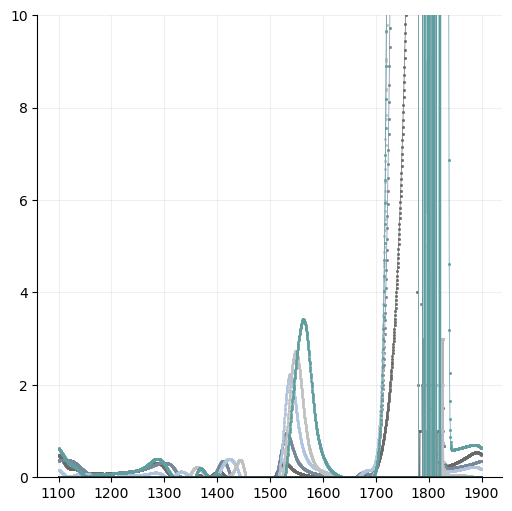

Layers: [('In0.5287729999999999Ga0.278092Al0.193135As', 100.0), ('In0.52964Ga0.329646Al0.140714As', 30.0), ('In0.5312116Ga0.423062Al0.0457264As', 30.0), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 67.0), ('In0.5287729999999999Ga0.278092Al0.193135As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5312116Ga0.423062Al0.0457264As': [0.30144642762184415, 0.8000976225011801, 0.0474219808, 0.054441474000000004, 0.46013949600000004, 3.540285053283713], 'In0.5319670000000012Ga0.468033Al-1.11468e-15As': [0.3187091531757405, 0.7499006886428017, 0.04359345199999986, 0.05074181499999985, 0.44680329999999957, 3.542847366859467], 'In0.5262359999999999Ga0.127191Al0.346573As': [0.15016434827436986, 1.239998987280111, 0.072611175, 0.07878286000000001, 0.5478825700000001, 3.5179

<Figure size 600x600 with 0 Axes>

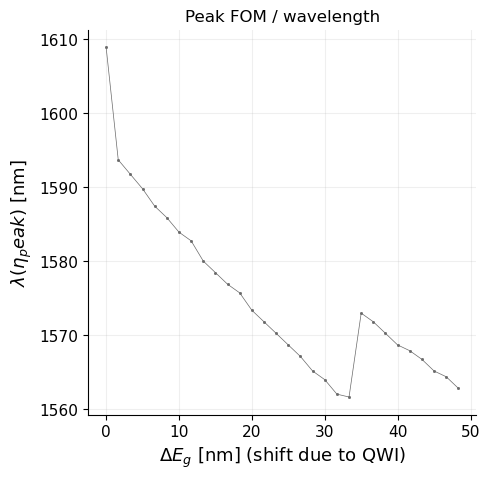

In [25]:
# layer1 = Layer(InAs, 50)
# InP_layer = Layer(InP, 100)
# layer5 = Layer(GaAs, 50)
# layer6 = Layer(GaP, 50)
# layer7 = Layer(AlAs, 50)

# layer2 = Layer(InGaAlAs_material(1610), 150)
# layer3 = Layer(InGaAlAs_material(1550), 180)
# layer7 = Layer(InGaAlAs_material(1200), 30)

# with open('input.txt', 'w') as f:
#     f.write(str(int(len(layers))) + "\n")
#     for layer in layers:
#         f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

# with open('materials.txt', 'w') as f:
#     for material in materials:
#         f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
#     for material in alloys:
#         f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.067, 0.08, 0.50, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.12, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.025, 0.40, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []

layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1549.81), 30)
layer3 = Layer(InGaAlAs_material(1549.81), 100)
layer5 = Layer(InGaAlAs_material(1700), 67)
layer6 = Layer(InGaAlAs_material(1000), 30)
layer4 = Layer(InGaAlAs_material(1350), 45)
InP_layer2 = Layer(InGaAlAs_material(1250), 100)
layer3 = Layer(InGaAlAs_material(1400.81), 30)
InP_layer = Layer(InGaAlAs_material(1229.85), 150)
layer10 = Layer(InGaAlAs_material(1350), 30)
layers = [InP_layer2, layer3,  InP_layer2]


# layers = [InP_layer2, layer5, layer2, layer10, InP_layer2]

# print("Initial Bandgap: " + str(getGap(layers)))

# with open('input.txt', 'w') as f:
#     f.write(str(int(len(layers))) + "\n")
#     for layer in layers:
#         f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

# with open('materials.txt', 'w') as f:
#     for material in materials:
#         f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
#     for material in alloys:
#         f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

        
num_electric_fields = 6 # simulation cxx - not python
max_electric_field = 9
max_wavelength_shift = 50 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", 0]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
#subprocess.run(['simulation_multithread.exe'])
for iter in range(1):
    alloys=[]
    clear_output()
    print("Run:" + str(iter))
#     layer3 = Layer(InGaAlAs_material(1495), 80)
#     InP_layer = Layer(InGaAlAs_material(1200), 100)
#     layers = [InP_layer, layer3, InP_layer]
#     with open('input.txt', 'w') as f:
#         f.write(str(int(len(layers))) + "\n")
#         for layer in layers:
#             f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")
#     with open('materials.txt', 'w') as f:
#         for material in materials:
#             f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
#         for material in alloys:
#             f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

    # print("Initial Bandgap: " + str(getGap(layers)))
    check = True
    # layers, check = findAlloys(layers, 1550)
    plot_FOM=[]
    plot_FOM_x=[]
    plot_FOM_MAX=[]
    plot_FOM_1550=[]
    plot_FOM_dn_dE=[]
    plot_FOM_dN_dE=[]
    wavelengths=[]
    if(check == True):
#         with open('input.txt', 'w') as f:
#             f.write(str(int(len(layers))) + "\n")
#             for layer in layers:
#                 f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

#         with open('materials.txt', 'w') as f:
#             for material in materials:
#                 f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
#             for material in alloys:
#                 f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        runsss=30
        for k in range(runsss):
            num_electric_fields = 7 # simulation cxx - not python
            max_electric_field = 11
            wavelength_shift = k*max_wavelength_shift/runsss #max_shift/num_runs + j*max_shift/num_runs

            QWI_params = ["True", wavelength_shift]
            # FOM_DATA_QWI_x.append(wavelength_shift)
            write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
            subprocess.run(['simulation_multithread_2.exe'])

            i=0
            data = []
            legend = []

            x_array, y_array_in = read_in("absorption_{}.txt".format(i))

            num_discrete = 1024 # Base 2 for FFT
            func_x = np.zeros(num_discrete)
            Gauss_y = np.zeros(num_discrete)
            Lorentz_y = np.zeros(num_discrete)
            x_0 = (x_array[len(x_array)-1]+x_array[0])/2
            print(x_0)
            gamma = 15

            sigma = 10

            for i in range(num_discrete):
                func_x[i] = x_array[i]
                Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
                Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

            Gauss_y = Gauss_y/abs(sum(Gauss_y))
            Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
            WL_xaxis = np.zeros(num_discrete)
            WL_axis_new = pad_func_linear(x_array) # for plotting
            Lorentz_y_new = pad_func_zeros(Lorentz_y)
            Gauss_y_new = pad_func_zeros(Gauss_y)
            voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
            func_x_new = pad_func_linear(func_x)
            #N_V = abs(max(voigt_y))
            #voigt_y /= N_V
            results=[]

            for i in range(0,num_electric_fields):
                y_array_in=[]
                x_array, y_array_in = read_in("absorption_{}.txt".format(i))
                y_array = pad_func_zeros(y_array_in)
                absorption = convolve(voigt_y, y_array)
                results.append(absorption)

            PLOT_LIMIT=[1450,1650]
            plot_graphs(func_x_new, results)

            PLOT_LIMIT=[]
            Y_LIMIT = []
            LEGEND=False
            label_x = ""
            label_y = ""
            plot_title = ""
            #plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])
            PLOT_LIMIT=[]

            FOM = np.zeros((8,2*num_discrete))
            FOM_1550 = np.zeros(8)
            max_FOM = np.zeros(8)
            index_1550 = np.abs(func_x_new - 1550).argmin()
            index_1450 = np.abs(func_x_new - 1490).argmin()
            index_1650 = np.abs(func_x_new - 1650).argmin()

            print("index_1450:", index_1450)
            print("index_1650:", index_1650)
            print(index_1550)
            wavelengths=[]
            for i in range(1,num_electric_fields):
                FOM[i-1] = results[i]/results[1]-1
                FOM_1550[i-1] = FOM[i-1][index_1550]
                #print(FOM_1550)
                max_FOM[i-1] = max(FOM[i-1][j] for j in range(index_1450,index_1650))
                index = np.abs(FOM[i-1] - max_FOM[i-1]).argmin()
                max_FOM_WL = func_x_new[index]
                wavelengths.append(max_FOM_WL)
                print(str(max_FOM[i-1])+" at "+str(max_FOM_WL))
            print(FOM_1550)
            dn_dE = (FOM_1550[2]-FOM_1550[1])/(3-2) # AU/(V/um)
            dN_DE = (max_FOM[2]-max_FOM[1])/(3-2)

            print("\n")
            print(dn_dE)
            MAX_FOM=max(FOM_1550)
            print(MAX_FOM)
            
            FOM_data = [MAX_FOM, dn_dE, max(max_FOM), dN_DE]
            
            index = np.abs(max_FOM - max(max_FOM)).argmin()
            print(index)
            plot_FOM.append(wavelengths[index])
            plot_FOM_x.append(wavelength_shift)
            plot_FOM_MAX.append(max(max_FOM))
            plot_FOM_1550.append(MAX_FOM)
            plot_FOM_dn_dE.append(dn_dE)
            plot_FOM_dN_dE.append(dN_DE)
            Y_LIMIT = [0,10]
            plot_graphs(func_x_new, FOM)
            Y_LIMIT=[]

            input_file = "input.txt"
            materials_file = "materials.txt"
            simulation_params_file = "simulation_parameters.txt"
            layers = parse_input_file(input_file)
            materials_out = parse_materials_file(materials_file)

            qwi_target_shift, num_electric_fields, efield = parse_simulation_parameters_file(simulation_params_file)
            print("Layers:", layers)
            print("Materials:", materials_out)
            print("QWI Target Shift:", qwi_target_shift)
            print("Number of Electric Fields:", num_electric_fields)
            print("Max Applied Electric Field:", max_electric_field)
            print("FOM:", FOM_data)
#             input_=[materials,layers,qwi_target_shift,max_applied_efield] 
#             #input_features_matrix.append(input_)
#             figure_of_merit = np.append(MAX_FOM, dn_dE) # result is max(FOM)
            data_dict = {
                "Layers": layers,
                "Materials": materials_out,
                "QWI Target Shift": qwi_target_shift,
                "Number of Electric Fields": num_electric_fields,
                "Max Applied Electric Field": max_electric_field,
                "FOM": FOM_data
            }
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            #write_data_to_file("Z:\FYP\data_{}.txt".format(timestamp), data_dict)
            
        plot_title = "Peak FOM / wavelength"
        label_x="$\Delta{}E_g$ [nm] (shift due to QWI)"
        label_y="$\lambda{}(\eta{}_peak)$ [nm]"
        aspect_ratio=[5,5]
        plot_graph(plot_FOM_x, plot_FOM)

<Figure size 500x500 with 0 Axes>

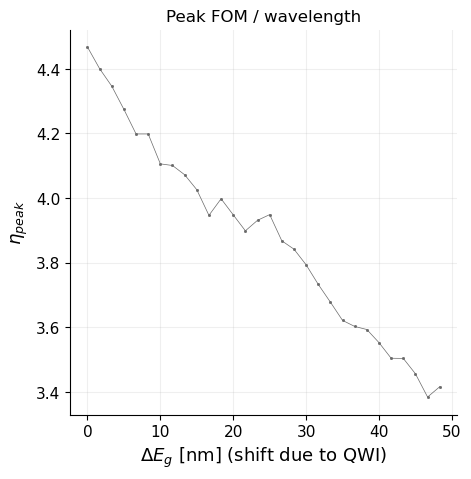

<Figure size 500x500 with 0 Axes>

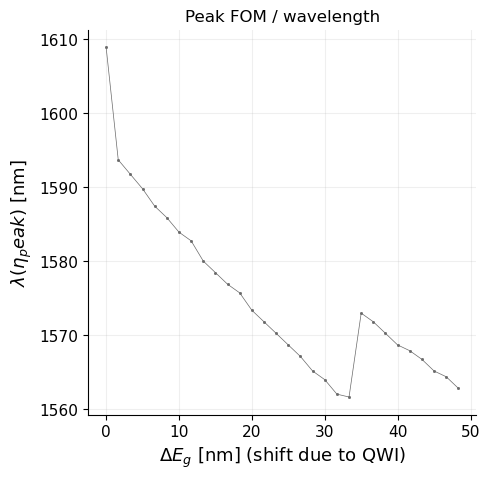

<Figure size 500x500 with 0 Axes>

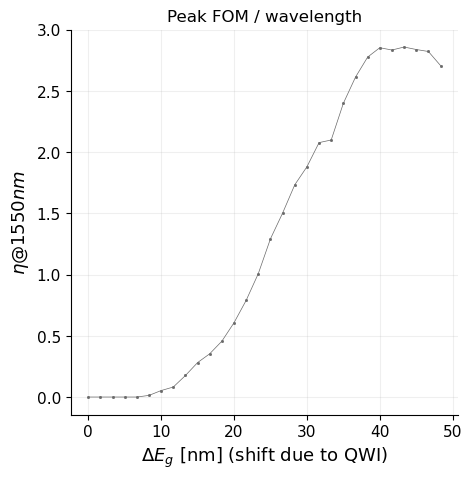

In [34]:
# PLOT_LIMIT=[1425,1650]
# plot_title="Absorption | Electric field  0 to 10V/$\mu$m"
# label_x="$\lambda{}$ [nm]"
# label_y="$\\alpha{}$ [AU]"
# plot_graphs(func_x_new, results)

plot_title = "Peak FOM / wavelength"
label_x="$\Delta{}E_g$ [nm] (shift due to QWI)"
label_y="$\eta{}_{peak}$"
aspect_ratio=[5,5]
plot_graph(plot_FOM_x, plot_FOM_MAX)

plot_title = "Peak FOM / wavelength"
label_x="$\Delta{}E_g$ [nm] (shift due to QWI)"
label_y="$\lambda{}(\eta{}_peak)$ [nm]"
aspect_ratio=[5,5]
plot_graph(plot_FOM_x, plot_FOM)

plot_title = "Peak FOM / wavelength"
label_x="$\Delta{}E_g$ [nm] (shift due to QWI)"
label_y="$\eta{} @ 1550 nm$"
aspect_ratio=[5,5]
plot_graph(plot_FOM_x, plot_FOM_1550)

In [8]:
def write_data_to_file(filename, data_dict):
    with open(filename, 'w') as f:
        for key, value in data_dict.items():
            f.write(f"{key}:\n")
            if isinstance(value, list):
                for item in value:
                    f.write(f"{item}\n")
            elif isinstance(value, dict):
                for subkey, subvalue in value.items():
                    f.write(f"{subkey}: {subvalue}\n")
            else:
                f.write(f"{value}\n")

def read_data_from_file(filename):
    data_dict = {}
    with open(filename, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
            key = lines[i].strip(":\n")
            i += 1
            if key in ["Layers", "Materials"]:
                data_dict[key] = {}
                while i < len(lines) and lines[i] != "\n":
                    line = lines[i].strip("\n")
                    if line and ":" in line:
                        subkey, subvalue = line.split(": ", 1)  # Limit split to 1 occurrence
                        data_dict[key][subkey] = subvalue
                    i += 1
            else:
                if i < len(lines):
                    value = lines[i].strip("\n")
                    data_dict[key] = value
                    i += 1
    return data_dict




# Sample data
# layers = [('InP', 100.0), ('In0.5314824Ga0.439174Al0.0293436As', 180.0), ('InP', 100.0)]
# materials = {'GaAs': [0.111, 1.42, 0.063, 0.082, 0.51, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.14, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.026, 0.41, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5316538Ga0.449376Al0.0189702As': [0.31173295583249855, 0.7701862290418768, 0.0433842554, 0.0537070628, 0.46214627599999997, 3.5419361757802292], 'In0.5312122Ga0.423147Al0.0456408As': [0.30147987984921865, 0.8000003493770904, 0.045722261599999994, 0.0558120992, 0.469658204, 3.540290998724055], 'In0.5283129999999999Ga0.250731Al0.220956As': [0.2212366328838581, 1.0333334315677287, 0.061090651999999995, 0.06964904, 0.51903638, 3.519742616325398], 'In0.5314642999999999Ga0.438139Al0.0303967As': [0.3074036836552433, 0.7827749821016479, 0.0443859409, 0.0546089418, 0.46536464599999994, 3.541285128552987], 'In0.5314824Ga0.439174Al0.0293436As': [0.3078068971747445, 0.7816025089422958, 0.0442935972, 0.0545257864, 0.465067968, 3.541348490164707]}
# qwi_target_shift = 0.0
# num_electric_fields = 10
# max_applied_efield = 10.0
# FOM_data = [-0.20272791518117428, 0.38468410085942684]

# Create data dictionary
data_dict = {
    "Layers": layers,
    "Materials": materials,
    "QWI Target Shift": qwi_target_shift,
    "Number of Electric Fields": num_electric_fields,
    "Max Applied Electric Field": max_electric_field,
    "FOM": FOM_data
}

# Write data to file
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
write_data_to_file("Z:\FYP\data_{timestamp}.txt", data_dict)

In [145]:
def read_data(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()

    # Extracting layers
    layers = []
    for line in data:
        if line.strip() == 'Layers:':
            break
    for line in data[data.index('Layers:\n') + 1:]:
        if line.strip() == 'Materials:':
            break
        layer_info = line.strip().replace("(", "").replace(")", "").replace("'", "").split(', ')
        layer = (layer_info[0], float(layer_info[1]))
        layers.append(layer)

    # Extracting materials
    materials = {}
    for line in data[data.index('Materials:\n') + 1:]:
        if line.strip() == 'QWI Target Shift:':
            break
        material_info = line.strip().split(': ')
        material_name = material_info[0]
        properties = [float(prop) for prop in material_info[1][1:-1].split(', ')]
        materials[material_name] = properties

    # Extracting QWI target shift
    qwi_target_shift = float(data[data.index('QWI Target Shift:\n') + 1])

    # Extracting number of electric fields
    number_of_electric_fields = int(data[data.index('Number of Electric Fields:\n') + 1])

    # Extracting max applied electric field
    max_applied_electric_field = int(data[data.index('Max Applied Electric Field:\n') + 1])

    # Extracting FOM elements
    fom_elements = [float(data[data.index('FOM:\n') + i]) for i in range(1, 3)]

    return materials, layers, qwi_target_shift, max_applied_electric_field, fom_elements


# Example usage:
file_path = 'data.txt'  # Replace 'your_file_path_here.txt' with the actual file path
materials, layers, qwi_target_shift, max_applied_electric_field, fom_elements = read_data(file_path)
input_ = [materials, layers, qwi_target_shift, max_applied_electric_field]
print(input_)
print(fom_elements)

[{'GaAs': [0.111, 1.42, 0.063, 0.082, 0.51, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.14, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.026, 0.41, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5316538Ga0.449376Al0.0189702As': [0.31173295583249855, 0.7701862290418768, 0.0433842554, 0.0537070628, 0.46214627599999997, 3.5419361757802292], 'In0.5312122Ga0.423147Al0.0456408As': [0.30147987984921865, 0.8000003493770904, 0.045722261599999994, 0.0558120992, 0.469658204, 3.540290998724055], 'In0.5283129999999999Ga0.250731Al0.220956As': [0.2212366328838581, 1.0333334315677287, 0.061090651999999995, 0.06964904, 0.51903638, 3.519742616325398], 'In0.5314642999999999Ga0.438139Al0.0303967As': [0.3074036836552433, 0.7827749821016479, 0.0443859409, 0.0546089418, 0.46536464599999994, 3.541285128552987], 'In0.5314824Ga0.439174Al0.0293436As': [0.3078068971747445, 0.7816025089422958, 0.0442935972, 0.0545257864, 0.465067968, 3.541348490164707]}, [

In [153]:
input_file = "input.txt"
materials_file = "materials.txt"
simulation_params_file = "simulation_parameters.txt"
layers = parse_input_file(input_file)
materials_out = parse_materials_file(materials_file)

qwi_target_shift, num_electric_fields, efield = parse_simulation_parameters_file(simulation_params_file)
print("Layers:", layers)
print("Materials:", materials_out)
print("QWI Target Shift:", qwi_target_shift)
print("Number of Electric Fields:", num_electric_fields)
print("Max Applied Electric Field:", max_electric_field)
print("FOM:", FOM_data)
#             input_=[materials,layers,qwi_target_shift,max_applied_efield] 
#             #input_features_matrix.append(input_)
#             figure_of_merit = np.append(MAX_FOM, dn_dE) # result is max(FOM)
data_dict = {
    "Layers": layers,
    "Materials": materials_out,
    "QWI Target Shift": qwi_target_shift,
    "Number of Electric Fields": num_electric_fields,
    "Max Applied Electric Field": max_electric_field,
    "FOM": FOM_data
}
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
write_data_to_file("Z:\FYP\data_{}.txt".format(timestamp), data_dict)

Layers: [('InP', 102.96558086984754), ('In0.5313511Ga0.431415Al0.0372339As', 258.9968545591504), ('InP', 102.96558086984754)]
Materials: {'GaAs': [0.111, 1.42, 0.063, 0.082, 0.51, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.14, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.026, 0.41, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5316538Ga0.449376Al0.0189702As': [0.31173295583249855, 0.7701862290418768, 0.0433842554, 0.0537070628, 0.46214627599999997, 3.5419361757802292], 'In0.5312122Ga0.423147Al0.0456408As': [0.30147987984921865, 0.8000003493770904, 0.045722261599999994, 0.0558120992, 0.469658204, 3.540290998724055], 'In0.5283129999999999Ga0.250731Al0.220956As': [0.2212366328838581, 1.0333334315677287, 0.061090651999999995, 0.06964904, 0.51903638, 3.519742616325398], 'In0.5313511Ga0.431415Al0.0372339As': [0.3047676904684835, 0.7904399811908012, 0.0449853053, 0.0551485826, 0.467290382, 3.5408572879752316]}
QWI Target Shift: 100.

In [40]:
FOM_DATA_QWI_x = []
FOM_DATA_QWI_y = []
FOM_DATA_QWI_y_all = []
max_shift = 50
num_runs = 20
num_electric_fields = 10 # simulation cxx - not python
max_electric_field = 10

def read_in(file_path):
    x_data_ = []
    y_data_ = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split the line into x and y values
                x_val, y_val = map(float, line.strip().split())
                x_data_.append(x_val)
                y_data_.append(y_val)
    except FileNotFoundError:
        print("File not found:", file_path)

materials = [GaAs, GaP, InP, InAs, AlAs]
# Write materials and layers information to files

for w in range(1):
    wavelength_shift = random.uniform(0, max_shift/num_runs)
    QWI_params = ["True", wavelength_shift]
    FOM_DATA_QWI_x.append(wavelength_shift)
    write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
    layer1 = Layer(InP, 50)
    layer2 = Layer(new_InGaAlAs_material(0.124, 0.0), 90)
    layer3 = Layer(new_InGaAlAs_material(0.15, 0.15), random.uniform(30, 100))
    layers = [layer1, layer3, layer1]

    with open('input.txt', 'w') as f:
        f.write(str(int(len(layers))) + "\n")
        for layer in layers:
            f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

    with open('materials.txt', 'w') as f:
        for material in materials:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        for material in alloys:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

    # Run the C++ executable with material and layer files
    #subprocess.run(['simulation with absorption.exe'])

    # Now x_array and y_array contain your data

    data = []
    legend = []

    i=0
    y_array_in=[]
    x_array=[]
    x_array, y_array_in = read_in("absorption_{}.txt".format(i))
    print(len(y_array_in))
    #voigt_y = voigt_y
    y_array = pad_func_zeros(y_array_in)
    print(len(y_array))
    absorption = convolve(voigt_y, y_array)
    plot_graph(func_x_new, absorption)
    results.append(absorption)

    num_discrete = 1024 # Base 2 for FFT
    func_x = np.zeros(num_discrete)
    Gauss_y = np.zeros(num_discrete)
    Lorentz_y = np.zeros(num_discrete)
    x_0 = (x_array[len(x_array)-1]+x_array[0])/2
    print(x_0)
    gamma = 15

    #WL_range=[1000,1400]
    #PLOT_LIMIT=WL_range
    #delta_WL = (WL_range[1]-WL_range[0]) / (num_discrete-1)
    #epsilon = delta_WL*0.5
    sigma = gamma

    for i in range(num_discrete):
        func_x[i] = x_array[i]
        Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
        Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

    Gauss_y = Gauss_y/abs(sum(Gauss_y))
    Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
    WL_xaxis = np.zeros(num_discrete)
    WL_axis_new = pad_func_linear(x_array) # for plotting
    Lorentz_y_new = pad_func_zeros(Lorentz_y)
    Gauss_y_new = pad_func_zeros(Gauss_y)
    voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
    func_x_new = pad_func_linear(func_x)
    N_V = abs(max(voigt_y))
    voigt_y /= N_V
    results=[]

    for i in range(0,11):
        y_array_in=[]
        x_array, y_array_in = read_in("absorption_{}.txt".format(i))
        y_array = pad_func_zeros(y_array_in)
        absorption = convolve(voigt_y, y_array)
        results.append(absorption)

    PLOT_LIMIT=[]
    plot_graphs(func_x_new, results)

    PLOT_LIMIT=[]
    Y_LIMIT = []
    LEGEND=False
    label_x = ""
    label_y = ""
    plot_title = ""
    
    # plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])
    
    # Example usage:
    input_file = "input.txt"
    materials_file = "materials.txt"
    simulation_params_file = "simulation_parameters.txt"
    layers = parse_input_file(input_file)
    materials = parse_materials_file(materials_file)
    
    
    for j in range (1,11):
        efield = j*max_electric_field/num_electric_fields
        qwi_target_shift, num_electric_fields, efield = parse_simulation_parameters_file(simulation_params_file)
        print("Layers:", layers)
        print("Materials:", materials)
        print("QWI Target Shift:", qwi_target_shift)
        print("Number of Electric Fields:", num_electric_fields)
        print("Max Applied Electric Field:", max_applied_efield)
        print("FOM:", result)
        input_=[materials,layers,qwi_target_shift,max_applied_efield] 
        input_features_matrix.append(input_)
        figure_of_merit = np.append(FOM[j], result) # result is max(FOM)
        
    # clear_output(wait=True)
    
    

NameError: name 'new_InGaAlAs_material' is not defined

In [ ]:
PLOT_LIMIT=[]
Y_LIMIT=[]
plot_graphs_distinct(x_values, y_values)
num_electric_fields = 10

print(read_in("absorption_{}.txt".format(i)))

In [ ]:
wavelength_shift = random.uniform(0, max_shift/num_runs)
QWI_params = ["True", wavelength_shift]
FOM_DATA_QWI_x.append(wavelength_shift)
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
layer1 = Layer(InP, 50)
layer2 = Layer(new_InGaAlAs_material(0.124, 0.0), 90)
layer3 = Layer(new_InGaAlAs_material(0.15, 0.15), random.uniform(30, 100))
layers = [layer1, layer3, layer1]

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

# Run the C++ executable with material and layer files
#subprocess.run(['simulation with absorption.exe'])

    # Convert lists to numpy arrays
#     x_array_ = np.array(x_data_)
#     y_array_ = np.array(y_data_)

    #plot_graph(x_array_, y_array_)

    #return x_array_, y_array_

# Now x_array and y_array contain your data

data = []
legend = []

i=0
#y_array_in=[]
x_array, y_array_in = read_in("absorption_{}.txt".format(i))
# print(len(y_array_in))
# #voigt_y = voigt_y
# y_array = pad_func_zeros(y_array_in)
# print(len(y_array))
# absorption = convolve(voigt_y, y_array)
# plot_graph(func_x_new, absorption)
# results.append(absorption)

num_discrete = 1024 # Base 2 for FFT
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = (x_array[len(x_array)-1]+x_array[0])/2
print(x_0)
gamma = 15

#WL_range=[1000,1400]
#PLOT_LIMIT=WL_range
#delta_WL = (WL_range[1]-WL_range[0]) / (num_discrete-1)
#epsilon = delta_WL*0.5
sigma = gamma

for i in range(num_discrete):
    func_x[i] = x_array[i]
    Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
    Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

Gauss_y = Gauss_y/abs(sum(Gauss_y))
Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
WL_xaxis = np.zeros(num_discrete)
WL_axis_new = pad_func_linear(x_array) # for plotting
Lorentz_y_new = pad_func_zeros(Lorentz_y)
Gauss_y_new = pad_func_zeros(Gauss_y)
voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
func_x_new = pad_func_linear(func_x)
N_V = abs(max(voigt_y))
voigt_y /= N_V
results=[]

for i in range(0,11):
    y_array_in=[]
    x_array, y_array_in = read_in("absorption_{}.txt".format(i))
    y_array = pad_func_zeros(y_array_in)
    absorption = convolve(voigt_y, y_array)
    results.append(absorption)

PLOT_LIMIT=[]
plot_graphs(func_x_new, results)

PLOT_LIMIT=[]
Y_LIMIT = []
LEGEND=False
label_x = ""
label_y = ""
plot_title = ""
#plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])

In [ ]:
PLOT_LIMIT=[1100,1400]
Y_LIMIT=[0,2500]
plot_graphs_distinct(x_values, y_values)
num_electric_fields = 10

In [ ]:
def read_in(file_path):
    x_data_ = []
    y_data_ = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split the line into x and y values
                x_val, y_val = map(float, line.strip().split())
                x_data_.append(x_val)
                y_data_.append(y_val)
    except FileNotFoundError:
        print("File not found:", file_path)

    # Convert lists to numpy arrays
    x_array_ = np.array(x_data_)
    y_array_ = np.array(y_data_)
    
    #plot_graph(x_array_, y_array_)
    
    return x_array_, y_array_

# Now x_array and y_array contain your data

data = []
legend = []

#y_array_in=[]
x_array, y_array_in = read_in("absorption_{}.txt".format(i))
# print(len(y_array_in))
# #voigt_y = voigt_y
# y_array = pad_func_zeros(y_array_in)
# print(len(y_array))
# absorption = convolve(voigt_y, y_array)
# plot_graph(func_x_new, absorption)
# results.append(absorption)
    
num_discrete = 1024 # Base 2 for FFT
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = (x_array[len(x_array)-1]+x_array[0])/2
print(x_0)
gamma = 15

#WL_range=[1000,1400]
#PLOT_LIMIT=WL_range
#delta_WL = (WL_range[1]-WL_range[0]) / (num_discrete-1)
#epsilon = delta_WL*0.5
sigma = gamma

for i in range(num_discrete):
    func_x[i] = x_array[i]
    Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
    Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

Gauss_y = Gauss_y/abs(sum(Gauss_y))
Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
WL_xaxis = np.zeros(num_discrete)
WL_axis_new = pad_func_linear(x_array) # for plotting
Lorentz_y_new = pad_func_zeros(Lorentz_y)
Gauss_y_new = pad_func_zeros(Gauss_y)
voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
func_x_new = pad_func_linear(func_x)
N_V = abs(max(voigt_y))
voigt_y /= N_V
results=[]

for i in range(0,11):
    y_array_in=[]
    x_array, y_array_in = read_in("absorption_{}.txt".format(i))
    y_array = pad_func_zeros(y_array_in)
    absorption = convolve(voigt_y, y_array)
    results.append(absorption)
    
PLOT_LIMIT=[]
plot_graphs(func_x_new, results)

PLOT_LIMIT=[]
Y_LIMIT = []
LEGEND=False
label_x = ""
label_y = ""
plot_title = ""
#plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])

In [ ]:
def parse_input_file(input_file):
    layers = []
    with open(input_file, 'r') as f:
        num_layers = int(f.readline().strip())
        for _ in range(num_layers):
            layer_info = f.readline().strip().split()
            material = layer_info[0]
            thickness = float(layer_info[1])
            layers.append((material, thickness))
    return layers

def parse_materials_file(materials_file):
    materials = {}
    with open(materials_file, 'r') as f:
        for line in f:
            material_info = line.strip().split()
            material = material_info[0]
            properties = [float(prop) for prop in material_info[1:]]
            materials[material] = properties
    return materials

def parse_simulation_parameters_file(simulation_params_file):
    with open(simulation_params_file, 'r') as f:
        qwi_target_shift = float(f.readline().strip())
        num_electric_fields = int(f.readline().strip())
        max_applied_efield = float(f.readline().strip())
    return qwi_target_shift, num_electric_fields, max_applied_efield

In [280]:
input_features_matrix=[]
figure_of_merit=[]

def parse_input_file(input_file):
    layers = []
    with open(input_file, 'r') as f:
        num_layers = int(f.readline().strip())
        for _ in range(num_layers):
            layer_info = f.readline().strip().split()
            material = layer_info[0]
            thickness = float(layer_info[1])
            layers.append((material, thickness))
    return layers

def parse_materials_file(materials_file):
    materials = {}
    with open(materials_file, 'r') as f:
        for line in f:
            material_info = line.strip().split()
            material = material_info[0]
            properties = [float(prop) for prop in material_info[1:]]
            materials[material] = properties
    return materials

def parse_simulation_parameters_file(simulation_params_file):
    with open(simulation_params_file, 'r') as f:
        qwi_target_shift = float(f.readline().split(" ")[1])
        num_electric_fields = int(f.readline().strip())
        max_applied_efield = float(f.readline().strip())
    return qwi_target_shift, num_electric_fields, max_applied_efield

# Example usage:
input_file = "input.txt"
materials_file = "materials.txt"
simulation_params_file = "simulation_parameters.txt"
layers = parse_input_file(input_file)
materials = parse_materials_file(materials_file)
qwi_target_shift, num_electric_fields, max_applied_efield = parse_simulation_parameters_file(simulation_params_file)


print("Layers:", layers)
print("Materials:", materials)
print("QWI Target Shift:", qwi_target_shift)
print("Number of Electric Fields:", num_electric_fields)
print("Max Applied Electric Field:", max_applied_efield)
print("FOM:", result)

input_=[materials,layers,qwi_target_shift,max_applied_efield] 

input_features_matrix.append(input_)
input_features_matrix
figure_of_merit = np.append(figure_of_merit, result) # result is max(FOM)

Layers: [('In0.528183Ga0.243024Al0.228793As', 89.0289077941682), ('In0.5313256Ga0.429848Al0.0388264As', 292.5981108718892), ('In0.528183Ga0.243024Al0.228793As', 89.0289077941682)]
Materials: {'GaAs': [0.111, 1.42, 0.063, 0.082, 0.51, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.14, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.026, 0.41, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5310663999999999Ga0.414452Al0.0544816As': [0.2979668979117418, 0.8102154756855429, 0.046497243199999996, 0.0565098464, 0.47214820799999996, 3.5396467989971483], 'In0.527835Ga0.222298Al0.249867As': [0.20587694824506203, 1.0779966611076999, 0.063625029, 0.07193086600000001, 0.52717926, 3.516192408697903], 'In0.528163Ga0.241809Al0.230028As': [0.21648136774867566, 1.0471608963399952, 0.061885916, 0.07036505600000001, 0.52159154, 3.518555674248365], 'In0.5313177Ga0.429388Al0.0392943As': [0.30396689613928185, 0.7927685485917946, 0.0451658961, 0.0553111642,

NameError: name 'result' is not defined

In [ ]:
print(len(input_features_matrix))
input_features_matrix

In [27]:
#     alloys=[]
#     clear_output()
#     print("Run:" + str(iter))
#     layer3 = Layer(InGaAlAs_material(random.uniform(1500, 1600)), random.uniform(50,130))
#     InP_layer = Layer(InGaAlAs_material(random.uniform(800,1350)), random.uniform(95,105))
#     layers = [InP_layer, layer3, InP_layer]
#     with open('input.txt', 'w') as f:
#         f.write(str(int(len(layers))) + "\n")
#         for layer in layers:
#             f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")
#     with open('materials.txt', 'w') as f:
#         for material in materials:
#             f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
#         for material in alloys:
#             f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

print("Initial Bandgap: " + str(getGap(layers)))
# layers, check = findAlloys(layers, 1550)
plot_FOM=[]
plot_FOM_x=[]
wavelengths=[]
if(check == True):
    with open('input.txt', 'w') as f:
        f.write(str(int(len(layers))) + "\n")
        for layer in layers:
            f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

    with open('materials.txt', 'w') as f:
        for material in materials:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        for material in alloys:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

    for k in range(10):
        num_electric_fields = 10 # simulation cxx - not python
        max_electric_field = 10
        wavelength_shift = k*50/10 #max_shift/num_runs + j*max_shift/num_runs

        QWI_params = ["True", wavelength_shift]
        FOM_DATA_QWI_x.append(wavelength_shift)
        write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
        subprocess.run(['simulation_multithread.exe'])

        i=0
        data = []
        legend = []

        x_array, y_array_in = read_in("absorption_{}.txt".format(i))

        num_discrete = 1024 # Base 2 for FFT
        func_x = np.zeros(num_discrete)
        Gauss_y = np.zeros(num_discrete)
        Lorentz_y = np.zeros(num_discrete)
        x_0 = (x_array[len(x_array)-1]+x_array[0])/2
        print(x_0)
        gamma = 15

        sigma = gamma

        for i in range(num_discrete):
            func_x[i] = x_array[i]
            Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
            Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

        Gauss_y = Gauss_y/abs(sum(Gauss_y))
        Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
        WL_xaxis = np.zeros(num_discrete)
        WL_axis_new = pad_func_linear(x_array) # for plotting
        Lorentz_y_new = pad_func_zeros(Lorentz_y)
        Gauss_y_new = pad_func_zeros(Gauss_y)
        voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
        func_x_new = pad_func_linear(func_x)
        #N_V = abs(max(voigt_y))
        #voigt_y /= N_V
        results=[]

        for i in range(0,10):
            y_array_in=[]
            x_array, y_array_in = read_in("absorption_{}.txt".format(i))
            y_array = pad_func_zeros(y_array_in)
            absorption = convolve(voigt_y, y_array)
            results.append(absorption)

        PLOT_LIMIT=[]
        plot_graphs(func_x_new, results)

        PLOT_LIMIT=[]
        Y_LIMIT = []
        LEGEND=False
        label_x = ""
        label_y = ""
        plot_title = ""
        #plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])
        PLOT_LIMIT=[]

        FOM = np.zeros((8,2*num_discrete))
        FOM_1550 = np.zeros(8)
        max_FOM = np.zeros(8)
        index_1550 = np.abs(func_x_new - 1550).argmin()
        index_1450 = np.abs(func_x_new - 1490).argmin()
        index_1650 = np.abs(func_x_new - 1650).argmin()

        print("index_1450:", index_1450)
        print("index_1650:", index_1650)
        print(index_1550)
        for i in range(1,9):
            FOM[i-1] = results[i]/results[1]-1
            FOM_1550[i-1] = FOM[i-1][index_1550]
            #print(FOM_1550)
            max_FOM[i-1] = max(FOM[i-1][j] for j in range(index_1450,index_1650))
            index = np.abs(FOM[i-1] - max_FOM[i-1]).argmin()
            max_FOM_WL = func_x_new[index]
            wavelengths.append(max_FOM_WL)
            print(str(max_FOM[i-1])+" at "+str(max_FOM_WL))
        print(FOM_1550)
        dn_dE = (FOM_1550[2]-FOM_1550[1])/(3-2) # AU/(V/um)
        dN_DE = (max_FOM[2]-max_FOM[1])/(3-2)

        print("\n")
        print(dn_dE)
        print(MAX_FOM)

        FOM_data = [MAX_FOM, dn_dE, max(max_FOM), dN_DE]

        index = np.where(max_FOM==max(max_FOM))

        plot_FOM.append(wavelengths[index])
        plot_FOM_x.append(k*5)

        Y_LIMIT = [0,10]
        plot_graphs(func_x_new, FOM)
        Y_LIMIT=[]

        input_file = "input.txt"
        materials_file = "materials.txt"
        simulation_params_file = "simulation_parameters.txt"
        layers = parse_input_file(input_file)
        materials_out = parse_materials_file(materials_file)

        qwi_target_shift, num_electric_fields, efield = parse_simulation_parameters_file(simulation_params_file)
        print("Layers:", layers)
        print("Materials:", materials_out)
        print("QWI Target Shift:", qwi_target_shift)
        print("Number of Electric Fields:", num_electric_fields)
        print("Max Applied Electric Field:", max_electric_field)
        print("FOM:", FOM_data)
#             input_=[materials,layers,qwi_target_shift,max_applied_efield] 
#             #input_features_matrix.append(input_)
#             figure_of_merit = np.append(MAX_FOM, dn_dE) # result is max(FOM)
        data_dict = {
            "Layers": layers,
            "Materials": materials_out,
            "QWI Target Shift": qwi_target_shift,
            "Number of Electric Fields": num_electric_fields,
            "Max Applied Electric Field": max_electric_field,
            "FOM": FOM_data
        }
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        write_data_to_file("Z:\FYP\data_{}.txt".format(timestamp), data_dict)

    plot_graph(plot_FOM, plot_FOM_x)

Initial Bandgap: 1549.1808706146626


NameError: name 'FOM_DATA_QWI_x' is not defined